### Import standard libraries and set directories

In [1]:
from atg import *
from tqdm import tqdm
import matplotlib.cm as cm
from ast import literal_eval

PATH=''
os.chdir(PATH)

#Set color palette
cmap=cm.get_cmap('gist_earth')
colors={'0':cmap(0.2), '1':cmap(0.4), '2':cmap(0.7), '3':cmap(0.9)}


#Set dictionaries
db_params=pickle.load(open(f"{PATH}/dicts/db_params.pickle", 'rb'))
city_names_final=pickle.load(open(f"{PATH}/dicts/city_names_final.pickle", 'rb'))
city_names_final_reverse={v:k for k,v in city_names_final.items()}
#Get list of cities included in paper
cities_list=query4table('cities_boundary', 'public', db_params, True)[['city','included_paper']]
cities_list=list(cities_included[cities_included['included_paper']==1]['city'])

###### Compute accessibility indices on grid of parameters

In [3]:
indeces_params={'min_dist':
                         {'index':'minimum_distance', 
                          'min_park_size':np.nan, 
                          'time_threshold':1000,  #Fake value - not used
                          'green_type':"{parks,forests,grass}", 
                          'source':'OSM',
                          'distances':'street-network'},
                    'exp':
                         {'index':'exposure', 
                          'min_park_size':0,
                          'time_threshold':np.nan,
                          'green_type':"{parks,forests,grass}", 
                          'source':'OSM',
                          'distances':'street-network',
                          'exposure_target':1000000 }, #Fake value - not used
                    'per_person':
                         {'index':'per_person', 
                          'min_park_size':np.nan, 
                          'time_threshold':np.nan, 
                          'green_type':"{parks,forests,grass}", 
                          'source':'OSM',
                          'distances':'street-network',
                          'exposure_target':1000000 }}

In [ ]:
bins_parksize=[0.5, 2, 5, 10, 25, 50, 75]
bins_parksize_short=[0.5, 5, 25, 75]
bins_timebudget=[5, 10, 15, 20, 30]
bins_timebudget_short=[5, 15, 30]

for city in cities_included:
    print(city)
    counter=0
    for i in ['min_dist', 'exp', 'per_person']:
        if i=='min_dist':
            for b in bins_parksize:
                print(i)
                print(b)
                counter=counter+1
                index_params=indeces_params[i]
                index_storage_name=f"{i}_{b}"
                index_params['min_park_size']=b
                min_intersection=min(0.025,index_params['min_park_size'])
                index=accessibility_index_pipeline(city, index_params, index_storage_name, db_params, min_intersection).drop(columns=[f'TargetSatisfied_{index_storage_name}'])
                if counter==1:
                    final=index.copy()
                else:
                    final=pd.merge(final, index, on=['id'])

        elif i=='exp':
            for b in bins_timebudget:
                print(i)
                print(b)
                counter=counter+1
                index_params=indeces_params[i]
                index_storage_name=f"{i}_{b}"
                index_params['time_threshold']=b
                min_intersection=min(0.025,index_params['min_park_size'])
                index=accessibility_index_pipeline(city, index_params, index_storage_name, db_params, min_intersection).drop(columns=[f'TargetSatisfied_{index_storage_name}'])
                if counter==1:
                    final=index.copy()
                else:
                    final=pd.merge(final, index, on=['id'])
                    
        elif i=='per_person':
            for b1 in bins_parksize_short:
                for b2 in bins_timebudget_short: 
                    print(i)
                    print(b1)
                    print(b2)
                    counter=counter+1
                    index_params=indeces_params[i]
                    index_storage_name=f"{i}_{b1}_{b2}"
                    index_params['min_park_size']=b1
                    index_params['time_threshold']=b2
                    min_intersection=min(0.025,index_params['min_park_size'])
                    index=accessibility_index_pipeline(city, index_params, index_storage_name, db_params, min_intersection).drop(columns=[f'TargetSatisfied_{index_storage_name}'])
                    if counter==1:
                        final=index.copy()
                    else:
                        final=pd.merge(final, index, on=['id'])
        
    final.to_csv(f"{PATH}/indices/{city}_stability_allindices.csv", index=False)

###### Define stability metrics and compute stability statistics

In [60]:
from scipy.stats import kendalltau

def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def gini_index(df, var1, weight): 
    
    tmp=df.copy()
    #Adjustment for non computed cell
    if 'min_dist' in var1:
        tmp.loc[tmp[var1]<0, var1]=tmp[var1].max()+tmp[var1].std()
    
    return gini(tmp[var1], tmp[weight])
      
def stable_naive_targeting(df, var1, var2, x): 
    
    tmp=df.copy()
    for_index1=sorted(tmp[var1].unique())
    cutoff1=[i for ind,i in enumerate(for_index1) if i>=x and (for_index1[ind-1]<x or ind==0)][0]
    del for_index1
    for_index2=sorted(tmp[var2].unique())
    cutoff2=[i for ind,i in enumerate(for_index2) if i>=x and (for_index2[ind-1]<x or ind==0)][0]
    del for_index2
    total_pop=tmp[(tmp[var1]<=cutoff1) | (tmp[var2]<=cutoff2)]['population'].sum()
    stable_population=tmp[(tmp[var1]<=cutoff1) & (tmp[var2]<=cutoff2)]['population'].sum()
    stable=stable_population/total_pop
    density_stable=tmp[(tmp[var1]<=cutoff1) & (tmp[var2]<=cutoff2)]['population'].mean()
    density_unstable=tmp[((tmp[var1]<=cutoff1) & (tmp[var2]>cutoff2)) | ((tmp[var1]>cutoff1) & (tmp[var2]<=cutoff2))]['population'].mean()
    
    return [stable, stable_population, total_pop, density_stable, density_unstable]

def stable_mostdisadvantaged_targeting(df, var1, var2, index_type, factor=4): 
    
    tmp=df.copy()
    #Adjustment for non computed cells, only needed for minimum distance
    if index_type=='min_dist':
        for var in [var1, var2]:
            tmp.loc[tmp[var]<0, var]=tmp[var].max()+tmp[var].std()
        
    if index_type=='min_dist':
        cutoff1=factor*sum(tmp[var1]*tmp['population'])/tmp['population'].sum()
        cutoff2=factor*sum(tmp[var2]*tmp['population'])/tmp['population'].sum()
    else:
        cutoff1=0
        cutoff2=0
        
    if index_type=='min_dist':    
        total_pop=tmp[(tmp[var1]>cutoff1) | (tmp[var2]>cutoff2)]['population'].sum()
        stable_population=tmp[(tmp[var1]>cutoff1) & (tmp[var2]>cutoff2)]['population'].sum()
        stable=stable_population/total_pop
        density_stable=tmp[(tmp[var1]>cutoff1) & (tmp[var2]>cutoff2)]['population'].mean()
        density_unstable=tmp[((tmp[var1]<=cutoff1) & (tmp[var2]>cutoff2)) | ((tmp[var1]>cutoff1) & (tmp[var2]<=cutoff2))]['population'].mean()

    else:    
        total_pop=tmp[(tmp[var1]<=cutoff1) | (tmp[var2]<=cutoff2)]['population'].sum()
        stable_population=tmp[(tmp[var1]<=cutoff1) & (tmp[var2]<=cutoff2)]['population'].sum()
        stable=stable_population/total_pop
        density_stable=tmp[(tmp[var1]<=cutoff1) & (tmp[var2]<=cutoff2)]['population'].mean()
        density_unstable=tmp[((tmp[var1]<=cutoff1) & (tmp[var2]>cutoff2)) | ((tmp[var1]>cutoff1) & (tmp[var2]<=cutoff2))]['population'].mean()

    return [stable, stable_population, total_pop, density_stable, density_unstable]
    
def kendall_rank_correlation(df, var1, var2):
    return kendalltau(df[var1], df[var2])

In [ ]:
bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75, 100]
bins_parksize_short=[0.5, 5, 25, 75]
bins_timebudget=[5, 10, 15, 20, 30]
bins_timebudget_short=[5, 15, 30]

for ind_city,city in tqdm(enumerate(cities_list)):


    df=pd.read_csv(f"{PATH}/data/indices/{city}_stability_all.csv")
    pop=query4grid_unmasked(f"{city}", db_params)
    n_rows=pop['y'].max()
    pop['id']=pop.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    inbound=query4grid(city, db_params)
    inbound=inbound[inbound['inbound']==1]
    inbound['id']=inbound.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    df=df[df['id'].isin(list(inbound['id']))]
    df=pd.merge(df, pop, on=['id'], how='left')

    gini_mindist=[]
    stable_mostdisadv_mindist_prop=[]
    stable_mostdisadv_mindist_stablepop=[]
    stable_mostdisadv_mindist_totalpop=[]
    stable_mostdisadv3_mindist_prop=[]
    stable_mostdisadv3_mindist_stablepop=[]
    stable_mostdisadv3_mindist_totalpop=[]
    stable_mostdisadv3_mindist_densitystable=[]
    stable_mostdisadv3_mindist_densityunstable=[]
    stable_mostdisadv5_mindist_prop=[]
    stable_mostdisadv5_mindist_stablepop=[]
    stable_mostdisadv5_mindist_totalpop=[]
    stable_naive1_mindist_prop=[]
    stable_naive1_mindist_stablepop=[]
    stable_naive1_mindist_totalpop=[]
    stable_naive2_mindist_prop=[]
    stable_naive2_mindist_stablepop=[]
    stable_naive2_mindist_totalpop=[]
    stable_naive2_mindist_densitystable=[]
    stable_naive2_mindist_densityunstable=[]
    stable_naive3_mindist_prop=[]
    stable_naive3_mindist_stablepop=[]
    stable_naive3_mindist_totalpop=[]
    stable_naive5_mindist_prop=[]
    stable_naive5_mindist_stablepop=[]
    stable_naive5_mindist_totalpop=[]
    stable_naive10_mindist_prop=[]
    stable_naive10_mindist_stablepop=[]
    stable_naive10_mindist_totalpop=[]
    cell_rankings_mindist=[]
    cell_rankings_mindist_pval=[]
    for ind,i in enumerate(bins_parksize):
        if i in [0.5, 1, 2, 5]:
            baseline=0.5
        elif i in [7.5, 10, 15, 25]:
            baseline=7.5
        else:
            baseline=50
        tmp=df.copy()
        gini_mindist.append(gini_index(tmp, f'min_dist_{i}', 'population'))
        s_prop, s, a, ds, dus=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{baseline}', f'min_dist_{i}', 'min_dist')
        stable_mostdisadv_mindist_prop.append(s_prop)
        stable_mostdisadv_mindist_stablepop.append(s)
        stable_mostdisadv_mindist_totalpop.append(a)
        s_prop, s, a, ds, dus=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{baseline}', f'min_dist_{i}', 'min_dist',3)
        stable_mostdisadv3_mindist_prop.append(s_prop)
        stable_mostdisadv3_mindist_stablepop.append(s)
        stable_mostdisadv3_mindist_totalpop.append(a)
        stable_mostdisadv3_mindist_densitystable.append(ds)
        stable_mostdisadv3_mindist_densityunstable.append(dus)
        s_prop, s, a, ds, dus=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{baseline}', f'min_dist_{i}', 'min_dist',5)
        stable_mostdisadv5_mindist_prop.append(s_prop)
        stable_mostdisadv5_mindist_stablepop.append(s)
        stable_mostdisadv5_mindist_totalpop.append(a)
        s_prop, s, a, ds, dus=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{baseline}', f'BetterThanEqual_min_dist_{i}', 0.10)
        stable_naive10_mindist_prop.append(s_prop)
        stable_naive10_mindist_stablepop.append(s)
        stable_naive10_mindist_totalpop.append(a)
        s_prop, s, a, ds, dus=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{baseline}', f'BetterThanEqual_min_dist_{i}', 0.05)
        stable_naive5_mindist_prop.append(s_prop)
        stable_naive5_mindist_stablepop.append(s)
        stable_naive5_mindist_totalpop.append(a)
        s_prop, s, a, ds, dus=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{baseline}', f'BetterThanEqual_min_dist_{i}', 0.03)
        stable_naive3_mindist_prop.append(s_prop)
        stable_naive3_mindist_stablepop.append(s)
        stable_naive3_mindist_totalpop.append(a)
        s_prop, s, a, ds, dus=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{baseline}', f'BetterThanEqual_min_dist_{i}', 0.02)
        stable_naive2_mindist_prop.append(s_prop)
        stable_naive2_mindist_stablepop.append(s)
        stable_naive2_mindist_totalpop.append(a)
        stable_naive2_mindist_densitystable.append(ds)
        stable_naive2_mindist_densityunstable.append(dus)
        s_prop, s, a, ds, dus=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{baseline}', f'BetterThanEqual_min_dist_{i}', 0.01)
        stable_naive1_mindist_prop.append(s_prop)
        stable_naive1_mindist_stablepop.append(s)
        stable_naive1_mindist_totalpop.append(a)
        cell_rankings_mindist.append(kendall_rank_correlation(tmp, f'BetterThanEqual_min_dist_{baseline}', f'BetterThanEqual_min_dist_{i}')[0])
        cell_rankings_mindist_pval.append(np.round(kendall_rank_correlation(tmp, f'BetterThanEqual_min_dist_{baseline}', f'BetterThanEqual_min_dist_{i}')[1], 4))

  
    df_forsaving=pd.DataFrame({'city':[city],
                              'Bins_parksize_MD':[[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75]], 
                              'Gini_MD': [gini_mindist],
                              'MostDisadvantaged_MD': [stable_mostdisadv_mindist_prop],
                              'MostDisadvantaged_MD_stablepop': [stable_mostdisadv_mindist_stablepop],
                              'MostDisadvantaged_MD_totalpop': [stable_mostdisadv_mindist_totalpop],
                              'MostDisadvantaged3_MD': [stable_mostdisadv3_mindist_prop],
                              'MostDisadvantaged3_MD_stablepop': [stable_mostdisadv3_mindist_stablepop],
                              'MostDisadvantaged3_MD_totalpop': [stable_mostdisadv3_mindist_totalpop],
                              'MostDisadvantaged3_MD_densitystable': [stable_mostdisadv3_mindist_densitystable],
                              'MostDisadvantaged3_MD_densityunstable': [stable_mostdisadv3_mindist_densityunstable],
                              'MostDisadvantaged5_MD': [stable_mostdisadv5_mindist_prop],
                              'MostDisadvantaged5_MD_stablepop': [stable_mostdisadv5_mindist_stablepop],
                              'MostDisadvantaged5_MD_totalpop': [stable_mostdisadv5_mindist_totalpop],
                              'Naive10_MD': [stable_naive10_mindist_prop],
                              'Naive10_MD_stablepop': [stable_naive10_mindist_stablepop],
                              'Naive10_MD_totalpop': [stable_naive10_mindist_totalpop],
                              'Naive5_MD': [stable_naive5_mindist_prop],
                              'Naive5_MD_stablepop': [stable_naive5_mindist_stablepop],
                              'Naive5_MD_totalpop': [stable_naive5_mindist_totalpop],
                              'Naive3_MD': [stable_naive3_mindist_prop],
                              'Naive3_MD_stablepop': [stable_naive3_mindist_stablepop],
                              'Naive3_MD_totalpop': [stable_naive3_mindist_totalpop],
                              'Naive2_MD': [stable_naive2_mindist_prop],
                              'Naive2_MD_stablepop': [stable_naive2_mindist_stablepop],
                              'Naive2_MD_totalpop': [stable_naive2_mindist_totalpop],
                              'Naive2_MD_densitystable': [stable_naive2_mindist_densitystable],
                              'Naive2_MD_densityunstable': [stable_naive2_mindist_densityunstable],
                              'Naive1_MD': [stable_naive1_mindist_prop],
                              'Naive1_MD_stablepop': [stable_naive1_mindist_stablepop],
                              'Naive1_MD_totalpop': [stable_naive1_mindist_totalpop],                            
                              'Ktau_MD': [cell_rankings_mindist], 
                              'Ktau_pval_MD': [cell_rankings_mindist_pval]})

    if ind_city==0:
        df_forsaving.to_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_MDonly_severalbaselines.csv", mode='w', index=False)
    else:
        df_forsaving.to_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_MDonly_severalbaselines.csv", mode='a', header=False, index=False)


In [ ]:
bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75]
bins_parksize_short=[0.5, 5, 25, 75]
bins_timebudget=[5, 10, 15, 20, 30]
bins_timebudget_short=[5, 15, 30]

for ind_city,city in tqdm(enumerate(cities_list)):


    df=pd.read_csv(f"{PATH}/indices/{city}_stability_allindices.csv")
    pop=query4grid_unmasked(f"{city}", db_params)
    n_rows=pop['y'].max()
    if 'id' not in df.columns:
        df['id']=df.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)

    pop['id']=pop.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    inbound=query4grid(city, db_params)
    inbound=inbound[inbound['inbound']==1]
    inbound['id']=inbound.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    df=df[df['id'].isin(list(inbound['id']))]
    df=pd.merge(df, pop, on=['id'], how='left')

    gini_mindist=[]
    stable_mostdisadv_mindist_prop=[]
    stable_mostdisadv_mindist_stablepop=[]
    stable_mostdisadv_mindist_totalpop=[]
    stable_mostdisadv3_mindist_prop=[]
    stable_mostdisadv3_mindist_stablepop=[]
    stable_mostdisadv3_mindist_totalpop=[]
    stable_mostdisadv5_mindist_prop=[]
    stable_mostdisadv5_mindist_stablepop=[]
    stable_mostdisadv5_mindist_totalpop=[]
    stable_naive1_mindist_prop=[]
    stable_naive1_mindist_stablepop=[]
    stable_naive1_mindist_totalpop=[]
    stable_naive2_mindist_prop=[]
    stable_naive2_mindist_stablepop=[]
    stable_naive2_mindist_totalpop=[]
    stable_naive3_mindist_prop=[]
    stable_naive3_mindist_stablepop=[]
    stable_naive3_mindist_totalpop=[]
    stable_naive5_mindist_prop=[]
    stable_naive5_mindist_stablepop=[]
    stable_naive5_mindist_totalpop=[]
    stable_naive10_mindist_prop=[]
    stable_naive10_mindist_stablepop=[]
    stable_naive10_mindist_totalpop=[]
    cell_rankings_mindist=[]
    cell_rankings_mindist_pval=[]
    for ind,i in enumerate(bins_parksize):
        tmp=df.copy()
        gini_mindist.append(gini_index(tmp, f'min_dist_{i}', 'population'))
        s_prop, s, a=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{bins_parksize[0]}', f'min_dist_{i}', 'min_dist')
        stable_mostdisadv_mindist_prop.append(s_prop)
        stable_mostdisadv_mindist_stablepop.append(s)
        stable_mostdisadv_mindist_totalpop.append(a)
        s_prop, s, a=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{bins_parksize[0]}', f'min_dist_{i}', 'min_dist',3)
        stable_mostdisadv3_mindist_prop.append(s_prop)
        stable_mostdisadv3_mindist_stablepop.append(s)
        stable_mostdisadv3_mindist_totalpop.append(a)
        s_prop, s, a=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{bins_parksize[0]}', f'min_dist_{i}', 'min_dist',5)
        stable_mostdisadv5_mindist_prop.append(s_prop)
        stable_mostdisadv5_mindist_stablepop.append(s)
        stable_mostdisadv5_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[0]}', f'BetterThanEqual_min_dist_{i}', 0.10)
        stable_naive10_mindist_prop.append(s_prop)
        stable_naive10_mindist_stablepop.append(s)
        stable_naive10_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[0]}', f'BetterThanEqual_min_dist_{i}', 0.05)
        stable_naive5_mindist_prop.append(s_prop)
        stable_naive5_mindist_stablepop.append(s)
        stable_naive5_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[0]}', f'BetterThanEqual_min_dist_{i}', 0.03)
        stable_naive3_mindist_prop.append(s_prop)
        stable_naive3_mindist_stablepop.append(s)
        stable_naive3_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[0]}', f'BetterThanEqual_min_dist_{i}', 0.02)
        stable_naive2_mindist_prop.append(s_prop)
        stable_naive2_mindist_stablepop.append(s)
        stable_naive2_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[0]}', f'BetterThanEqual_min_dist_{i}', 0.01)
        stable_naive1_mindist_prop.append(s_prop)
        stable_naive1_mindist_stablepop.append(s)
        stable_naive1_mindist_totalpop.append(a)
        cell_rankings_mindist.append(kendall_rank_correlation(tmp, f'BetterThanEqual_min_dist_{bins_parksize[0]}', f'BetterThanEqual_min_dist_{i}')[0])
        cell_rankings_mindist_pval.append(np.round(kendall_rank_correlation(tmp, f'BetterThanEqual_min_dist_{bins_parksize[0]}', f'BetterThanEqual_min_dist_{i}')[1], 4))

    gini_exp=[]
    stable_mostdisadv_exp_prop=[]
    stable_mostdisadv_exp_stablepop=[]
    stable_mostdisadv_exp_totalpop=[]
    stable_naive1_exp_prop=[]
    stable_naive1_exp_stablepop=[]
    stable_naive1_exp_totalpop=[]
    stable_naive2_exp_prop=[]
    stable_naive2_exp_stablepop=[]
    stable_naive2_exp_totalpop=[]
    stable_naive3_exp_prop=[]
    stable_naive3_exp_stablepop=[]
    stable_naive3_exp_totalpop=[]
    stable_naive5_exp_prop=[]
    stable_naive5_exp_stablepop=[]
    stable_naive5_exp_totalpop=[]
    stable_naive10_exp_prop=[]
    stable_naive10_exp_stablepop=[]
    stable_naive10_exp_totalpop=[]
    cell_rankings_exp=[]
    cell_rankings_exp_pval=[]
    for ind,i in enumerate(bins_timebudget):
        tmp=df.copy()
        gini_exp.append(gini_index(tmp, f'exp_{i}', 'population'))
        s_prop, s, a =stable_mostdisadvantaged_targeting(tmp, f'exp_{bins_timebudget[0]}', f'exp_{i}', 'exp')
        stable_mostdisadv_exp_prop.append(s_prop)
        stable_mostdisadv_exp_stablepop.append(s)
        stable_mostdisadv_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}', 0.10)
        stable_naive10_exp_prop.append(s_prop)
        stable_naive10_exp_stablepop.append(s)
        stable_naive10_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}', 0.05)
        stable_naive5_exp_prop.append(s_prop)
        stable_naive5_exp_stablepop.append(s)
        stable_naive5_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}', 0.03)
        stable_naive3_exp_prop.append(s_prop)
        stable_naive3_exp_stablepop.append(s)
        stable_naive3_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}', 0.02)
        stable_naive2_exp_prop.append(s_prop)
        stable_naive2_exp_stablepop.append(s)
        stable_naive2_exp_totalpop.append(a)    
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}', 0.01)
        stable_naive1_exp_prop.append(s_prop)
        stable_naive1_exp_stablepop.append(s)
        stable_naive1_exp_totalpop.append(a)  
        cell_rankings_exp.append(kendall_rank_correlation(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}')[0])
        cell_rankings_exp_pval.append(np.round(kendall_rank_correlation(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}')[1], 4))

    gini_pp=[]
    stable_mostdisadv_pp_prop=[]
    stable_mostdisadv_pp_stablepop=[]
    stable_mostdisadv_pp_totalpop=[]
    stable_naive1_pp_prop=[]
    stable_naive1_pp_stablepop=[]
    stable_naive1_pp_totalpop=[]
    stable_naive2_pp_prop=[]
    stable_naive2_pp_stablepop=[]
    stable_naive2_pp_totalpop=[]
    stable_naive3_pp_prop=[]
    stable_naive3_pp_stablepop=[]
    stable_naive3_pp_totalpop=[]
    stable_naive5_pp_prop=[]
    stable_naive5_pp_stablepop=[]
    stable_naive5_pp_totalpop=[]
    stable_naive10_pp_prop=[]
    stable_naive10_pp_stablepop=[]
    stable_naive10_pp_totalpop=[]
    cell_rankings_pp=[]
    cell_rankings_pp_pval=[]
    for indi,i in enumerate(bins_parksize_short):
        for indj,j in enumerate(bins_timebudget_short):
            tmp=df.copy()
            gini_pp.append(gini_index(tmp, f'per_person_{i}_{j}', 'population'))
            s_prop, s, a=stable_mostdisadvantaged_targeting(tmp,  f'per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'per_person_{i}_{j}', 'pp')
            stable_mostdisadv_pp_prop.append(s_prop)
            stable_mostdisadv_pp_stablepop.append(s)
            stable_mostdisadv_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.10)
            stable_naive10_pp_prop.append(s_prop)
            stable_naive10_pp_stablepop.append(s)
            stable_naive10_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.05)
            stable_naive5_pp_prop.append(s_prop)
            stable_naive5_pp_stablepop.append(s)
            stable_naive5_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.03)
            stable_naive3_pp_prop.append(s_prop)
            stable_naive3_pp_stablepop.append(s)
            stable_naive3_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.02)
            stable_naive2_pp_prop.append(s_prop)
            stable_naive2_pp_stablepop.append(s)
            stable_naive2_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.01)
            stable_naive1_pp_prop.append(s_prop)
            stable_naive1_pp_stablepop.append(s)
            stable_naive1_pp_totalpop.append(a)
            cell_rankings_pp.append(kendall_rank_correlation(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}')[0])
            cell_rankings_pp_pval.append(np.round(kendall_rank_correlation(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[0]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}')[1], 4))

    df_forsaving=pd.DataFrame({'city':[city],
                              'Bins_parksize_MD':[[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75]], 
                              'Bins_parksize_PP':[[0.5, 5, 25, 75]],
                              'Bins_timebudget_EXP':[[5, 10, 15, 20, 30]],
                              'Bins_timebudget_PP':[[5, 15, 30]],
                              'Gini_MD': [gini_mindist],
                              'MostDisadvantaged_MD': [stable_mostdisadv_mindist_prop],
                              'MostDisadvantaged_MD_stablepop': [stable_mostdisadv_mindist_stablepop],
                              'MostDisadvantaged_MD_totalpop': [stable_mostdisadv_mindist_totalpop],
                              'MostDisadvantaged3_MD': [stable_mostdisadv3_mindist_prop],
                              'MostDisadvantaged3_MD_stablepop': [stable_mostdisadv3_mindist_stablepop],
                              'MostDisadvantaged3_MD_totalpop': [stable_mostdisadv3_mindist_totalpop],
                              'MostDisadvantaged5_MD': [stable_mostdisadv5_mindist_prop],
                              'MostDisadvantaged5_MD_stablepop': [stable_mostdisadv5_mindist_stablepop],
                              'MostDisadvantaged5_MD_totalpop': [stable_mostdisadv5_mindist_totalpop],
                              'Naive10_MD': [stable_naive10_mindist_prop],
                              'Naive10_MD_stablepop': [stable_naive10_mindist_stablepop],
                              'Naive10_MD_totalpop': [stable_naive10_mindist_totalpop],
                              'Naive5_MD': [stable_naive5_mindist_prop],
                              'Naive5_MD_stablepop': [stable_naive5_mindist_stablepop],
                              'Naive5_MD_totalpop': [stable_naive5_mindist_totalpop],
                              'Naive3_MD': [stable_naive3_mindist_prop],
                              'Naive3_MD_stablepop': [stable_naive3_mindist_stablepop],
                              'Naive3_MD_totalpop': [stable_naive3_mindist_totalpop],
                              'Naive2_MD': [stable_naive2_mindist_prop],
                              'Naive2_MD_stablepop': [stable_naive2_mindist_stablepop],
                              'Naive2_MD_totalpop': [stable_naive2_mindist_totalpop],
                              'Naive1_MD': [stable_naive1_mindist_prop],
                              'Naive1_MD_stablepop': [stable_naive1_mindist_stablepop],
                              'Naive1_MD_totalpop': [stable_naive1_mindist_totalpop],                            
                              'Ktau_MD': [cell_rankings_mindist], 
                              'Ktau_pval_MD': [cell_rankings_mindist_pval], 
                              'Gini_EXP': [gini_exp],
                              'MostDisadvantaged_EXP': [stable_mostdisadv_exp_prop],
                              'MostDisadvantaged_EXP_stablepop': [stable_mostdisadv_exp_stablepop],
                              'MostDisadvantaged_EXP_totalpop': [stable_mostdisadv_exp_totalpop],
                              'Naive10_EXP': [stable_naive10_exp_prop],
                              'Naive10_EXP_stablepop': [stable_naive10_exp_stablepop],
                              'Naive10_EXP_totalpop': [stable_naive10_exp_totalpop],
                              'Naive5_EXP': [stable_naive5_exp_prop],
                              'Naive5_EXP_stablepop': [stable_naive5_exp_stablepop],
                              'Naive5_EXP_totalpop': [stable_naive5_exp_totalpop],
                              'Naive3_EXP': [stable_naive3_exp_prop],
                              'Naive3_EXP_stablepop': [stable_naive3_exp_stablepop],
                              'Naive3_EXP_totalpop': [stable_naive3_exp_totalpop],
                              'Naive2_EXP': [stable_naive2_exp_prop],
                              'Naive2_EXP_stablepop': [stable_naive2_exp_stablepop],
                              'Naive2_EXP_totalpop': [stable_naive2_exp_totalpop],
                              'Naive1_EXP': [stable_naive1_exp_prop],
                              'Naive1_EXP_stablepop': [stable_naive1_exp_stablepop],
                              'Naive1_EXP_totalpop': [stable_naive1_exp_totalpop],                            
                              'Ktau_EXP': [cell_rankings_exp], 
                              'Ktau_pval_EXP': [cell_rankings_exp_pval], 
                              'Gini_PP': [gini_pp],
                              'MostDisadvantaged_PP': [stable_mostdisadv_pp_prop],
                              'MostDisadvantaged_PP_stablepop': [stable_mostdisadv_pp_stablepop],
                              'MostDisadvantaged_PP_totalpop': [stable_mostdisadv_pp_totalpop],
                              'Naive10_PP': [stable_naive10_pp_prop],
                              'Naive10_PP_stablepop': [stable_naive10_pp_stablepop],
                              'Naive10_PP_totalpop': [stable_naive10_pp_totalpop],
                              'Naive5_PP': [stable_naive5_pp_prop],
                              'Naive5_PP_stablepop': [stable_naive5_pp_stablepop],
                              'Naive5_PP_totalpop': [stable_naive5_pp_totalpop],
                              'Naive3_PP': [stable_naive3_pp_prop],
                              'Naive3_PP_stablepop': [stable_naive3_pp_stablepop],
                              'Naive3_PP_totalpop': [stable_naive3_pp_totalpop],
                              'Naive2_PP': [stable_naive2_pp_prop],
                              'Naive2_PP_stablepop': [stable_naive2_pp_stablepop],
                              'Naive2_PP_totalpop': [stable_naive2_pp_totalpop],
                              'Naive1_PP': [stable_naive1_pp_prop],
                              'Naive1_PP_stablepop': [stable_naive1_pp_stablepop],
                              'Naive1_PP_totalpop': [stable_naive1_pp_totalpop], 
                              'Ktau_PP': [cell_rankings_pp], 
                              'Ktau_pval_PP': [cell_rankings_pp_pval]})

    if ind_city==0:
        df_forsaving.to_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_firstbin.csv", mode='w', index=False)
    else:
        df_forsaving.to_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_firstbin.csv", mode='a', header=False, index=False)


In [ ]:
bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75]
bins_parksize_short=[0.5, 5, 25, 75]
bins_timebudget=[5, 10, 15, 20, 30]
bins_timebudget_short=[5, 15, 30]

for ind_city,city in tqdm(enumerate(cities_list)):


    df=pd.read_csv(f"{PATH}/indices/{city}_stability_allindices.csv")
    pop=query4grid_unmasked(f"{city}", db_params)
    n_rows=pop['y'].max()
    if 'id' not in df.columns:
        df['id']=df.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)

    pop['id']=pop.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    inbound=query4grid(city, db_params)
    inbound=inbound[inbound['inbound']==1]
    inbound['id']=inbound.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    df=df[df['id'].isin(list(inbound['id']))]
    df=pd.merge(df, pop, on=['id'], how='left')

    gini_mindist=[]
    stable_mostdisadv_mindist_prop=[]
    stable_mostdisadv_mindist_stablepop=[]
    stable_mostdisadv_mindist_totalpop=[]
    stable_mostdisadv3_mindist_prop=[]
    stable_mostdisadv3_mindist_stablepop=[]
    stable_mostdisadv3_mindist_totalpop=[]
    stable_mostdisadv5_mindist_prop=[]
    stable_mostdisadv5_mindist_stablepop=[]
    stable_mostdisadv5_mindist_totalpop=[]
    stable_naive1_mindist_prop=[]
    stable_naive1_mindist_stablepop=[]
    stable_naive1_mindist_totalpop=[]
    stable_naive2_mindist_prop=[]
    stable_naive2_mindist_stablepop=[]
    stable_naive2_mindist_totalpop=[]
    stable_naive3_mindist_prop=[]
    stable_naive3_mindist_stablepop=[]
    stable_naive3_mindist_totalpop=[]
    stable_naive5_mindist_prop=[]
    stable_naive5_mindist_stablepop=[]
    stable_naive5_mindist_totalpop=[]
    stable_naive10_mindist_prop=[]
    stable_naive10_mindist_stablepop=[]
    stable_naive10_mindist_totalpop=[]
    cell_rankings_mindist=[]
    cell_rankings_mindist_pval=[]
    for ind,i in enumerate(bins_parksize):
        if ind==0:
            baseline_bin=0
        else:
            baseline_bin=ind-1
        tmp=df.copy()
        gini_mindist.append(gini_index(tmp, f'min_dist_{i}', 'population'))
        s_prop, s, a=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{bins_parksize[baseline_bin]}', f'min_dist_{i}', 'min_dist')
        stable_mostdisadv_mindist_prop.append(s_prop)
        stable_mostdisadv_mindist_stablepop.append(s)
        stable_mostdisadv_mindist_totalpop.append(a)
        s_prop, s, a=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{bins_parksize[baseline_bin]}', f'min_dist_{i}', 'min_dist',3)
        stable_mostdisadv3_mindist_prop.append(s_prop)
        stable_mostdisadv3_mindist_stablepop.append(s)
        stable_mostdisadv3_mindist_totalpop.append(a)
        s_prop, s, a=stable_mostdisadvantaged_targeting(tmp, f'min_dist_{bins_parksize[baseline_bin]}', f'min_dist_{i}', 'min_dist',5)
        stable_mostdisadv5_mindist_prop.append(s_prop)
        stable_mostdisadv5_mindist_stablepop.append(s)
        stable_mostdisadv5_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[baseline_bin]}', f'BetterThanEqual_min_dist_{i}', 0.10)
        stable_naive10_mindist_prop.append(s_prop)
        stable_naive10_mindist_stablepop.append(s)
        stable_naive10_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[baseline_bin]}', f'BetterThanEqual_min_dist_{i}', 0.05)
        stable_naive5_mindist_prop.append(s_prop)
        stable_naive5_mindist_stablepop.append(s)
        stable_naive5_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[baseline_bin]}', f'BetterThanEqual_min_dist_{i}', 0.03)
        stable_naive3_mindist_prop.append(s_prop)
        stable_naive3_mindist_stablepop.append(s)
        stable_naive3_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[baseline_bin]}', f'BetterThanEqual_min_dist_{i}', 0.02)
        stable_naive2_mindist_prop.append(s_prop)
        stable_naive2_mindist_stablepop.append(s)
        stable_naive2_mindist_totalpop.append(a)
        s_prop, s, a=stable_naive_targeting(tmp, f'BetterThanEqual_min_dist_{bins_parksize[baseline_bin]}', f'BetterThanEqual_min_dist_{i}', 0.01)
        stable_naive1_mindist_prop.append(s_prop)
        stable_naive1_mindist_stablepop.append(s)
        stable_naive1_mindist_totalpop.append(a)
        cell_rankings_mindist.append(kendall_rank_correlation(tmp, f'BetterThanEqual_min_dist_{bins_parksize[baseline_bin]}', f'BetterThanEqual_min_dist_{i}')[0])
        cell_rankings_mindist_pval.append(np.round(kendall_rank_correlation(tmp, f'BetterThanEqual_min_dist_{bins_parksize[baseline_bin]}', f'BetterThanEqual_min_dist_{i}')[1], 4))

    gini_exp=[]
    stable_mostdisadv_exp_prop=[]
    stable_mostdisadv_exp_stablepop=[]
    stable_mostdisadv_exp_totalpop=[]
    stable_naive1_exp_prop=[]
    stable_naive1_exp_stablepop=[]
    stable_naive1_exp_totalpop=[]
    stable_naive2_exp_prop=[]
    stable_naive2_exp_stablepop=[]
    stable_naive2_exp_totalpop=[]
    stable_naive3_exp_prop=[]
    stable_naive3_exp_stablepop=[]
    stable_naive3_exp_totalpop=[]
    stable_naive5_exp_prop=[]
    stable_naive5_exp_stablepop=[]
    stable_naive5_exp_totalpop=[]
    stable_naive10_exp_prop=[]
    stable_naive10_exp_stablepop=[]
    stable_naive10_exp_totalpop=[]
    cell_rankings_exp=[]
    cell_rankings_exp_pval=[]
    for ind,i in enumerate(bins_timebudget):
        if ind==0:
            baseline_bin=0
        else:
            baseline_bin=ind-1
        tmp=df.copy()
        gini_exp.append(gini_index(tmp, f'exp_{i}', 'population'))
        s_prop, s, a =stable_mostdisadvantaged_targeting(tmp, f'exp_{bins_timebudget[baseline_bin]}', f'exp_{i}', 'exp')
        stable_mostdisadv_exp_prop.append(s_prop)
        stable_mostdisadv_exp_stablepop.append(s)
        stable_mostdisadv_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[baseline_bin]}', f'BetterThanEqual_exp_{i}', 0.10)
        stable_naive10_exp_prop.append(s_prop)
        stable_naive10_exp_stablepop.append(s)
        stable_naive10_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[baseline_bin]}', f'BetterThanEqual_exp_{i}', 0.05)
        stable_naive5_exp_prop.append(s_prop)
        stable_naive5_exp_stablepop.append(s)
        stable_naive5_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[baseline_bin]}', f'BetterThanEqual_exp_{i}', 0.03)
        stable_naive3_exp_prop.append(s_prop)
        stable_naive3_exp_stablepop.append(s)
        stable_naive3_exp_totalpop.append(a)
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[baseline_bin]}', f'BetterThanEqual_exp_{i}', 0.02)
        stable_naive2_exp_prop.append(s_prop)
        stable_naive2_exp_stablepop.append(s)
        stable_naive2_exp_totalpop.append(a)    
        s_prop, s, a =stable_naive_targeting(tmp, f'BetterThanEqual_exp_{bins_timebudget[baseline_bin]}', f'BetterThanEqual_exp_{i}', 0.01)
        stable_naive1_exp_prop.append(s_prop)
        stable_naive1_exp_stablepop.append(s)
        stable_naive1_exp_totalpop.append(a)  
        cell_rankings_exp.append(kendall_rank_correlation(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}')[0])
        cell_rankings_exp_pval.append(np.round(kendall_rank_correlation(tmp, f'BetterThanEqual_exp_{bins_timebudget[0]}', f'BetterThanEqual_exp_{i}')[1], 4))

    gini_pp=[]
    stable_mostdisadv_pp_prop=[]
    stable_mostdisadv_pp_stablepop=[]
    stable_mostdisadv_pp_totalpop=[]
    stable_naive1_pp_prop=[]
    stable_naive1_pp_stablepop=[]
    stable_naive1_pp_totalpop=[]
    stable_naive2_pp_prop=[]
    stable_naive2_pp_stablepop=[]
    stable_naive2_pp_totalpop=[]
    stable_naive3_pp_prop=[]
    stable_naive3_pp_stablepop=[]
    stable_naive3_pp_totalpop=[]
    stable_naive5_pp_prop=[]
    stable_naive5_pp_stablepop=[]
    stable_naive5_pp_totalpop=[]
    stable_naive10_pp_prop=[]
    stable_naive10_pp_stablepop=[]
    stable_naive10_pp_totalpop=[]
    cell_rankings_pp=[]
    cell_rankings_pp_pval=[]
    for indi,i in enumerate(bins_parksize_short):
        for indj,j in enumerate(bins_timebudget_short):
            if indi==0:
                baseline_bin=0
            else:
                baseline_bin=indi-1
            tmp=df.copy()
            gini_pp.append(gini_index(tmp, f'per_person_{i}_{j}', 'population'))
            s_prop, s, a=stable_mostdisadvantaged_targeting(tmp,  f'per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'per_person_{i}_{j}', 'pp')
            stable_mostdisadv_pp_prop.append(s_prop)
            stable_mostdisadv_pp_stablepop.append(s)
            stable_mostdisadv_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.10)
            stable_naive10_pp_prop.append(s_prop)
            stable_naive10_pp_stablepop.append(s)
            stable_naive10_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.05)
            stable_naive5_pp_prop.append(s_prop)
            stable_naive5_pp_stablepop.append(s)
            stable_naive5_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.03)
            stable_naive3_pp_prop.append(s_prop)
            stable_naive3_pp_stablepop.append(s)
            stable_naive3_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.02)
            stable_naive2_pp_prop.append(s_prop)
            stable_naive2_pp_stablepop.append(s)
            stable_naive2_pp_totalpop.append(a)
            s_prop, s, a=stable_naive_targeting(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}', 0.01)
            stable_naive1_pp_prop.append(s_prop)
            stable_naive1_pp_stablepop.append(s)
            stable_naive1_pp_totalpop.append(a)
            cell_rankings_pp.append(kendall_rank_correlation(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}')[0])
            cell_rankings_pp_pval.append(np.round(kendall_rank_correlation(tmp,  f'BetterThanEqual_per_person_{bins_parksize_short[baseline_bin]}_{bins_timebudget_short[0]}', f'BetterThanEqual_per_person_{i}_{j}')[1], 4))

    df_forsaving=pd.DataFrame({'city':[city],
                              'Bins_parksize_MD':[[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75]], 
                              'Bins_parksize_PP':[[0.5, 5, 25, 75]],
                              'Bins_timebudget_EXP':[[5, 10, 15, 20, 30]],
                              'Bins_timebudget_PP':[[5, 15, 30]],
                              'Gini_MD': [gini_mindist],
                              'MostDisadvantaged_MD': [stable_mostdisadv_mindist_prop],
                              'MostDisadvantaged_MD_stablepop': [stable_mostdisadv_mindist_stablepop],
                              'MostDisadvantaged_MD_totalpop': [stable_mostdisadv_mindist_totalpop],
                              'MostDisadvantaged3_MD': [stable_mostdisadv3_mindist_prop],
                              'MostDisadvantaged3_MD_stablepop': [stable_mostdisadv3_mindist_stablepop],
                              'MostDisadvantaged3_MD_totalpop': [stable_mostdisadv3_mindist_totalpop],
                              'MostDisadvantaged5_MD': [stable_mostdisadv5_mindist_prop],
                              'MostDisadvantaged5_MD_stablepop': [stable_mostdisadv5_mindist_stablepop],
                              'MostDisadvantaged5_MD_totalpop': [stable_mostdisadv5_mindist_totalpop],
                              'Naive10_MD': [stable_naive10_mindist_prop],
                              'Naive10_MD_stablepop': [stable_naive10_mindist_stablepop],
                              'Naive10_MD_totalpop': [stable_naive10_mindist_totalpop],
                              'Naive5_MD': [stable_naive5_mindist_prop],
                              'Naive5_MD_stablepop': [stable_naive5_mindist_stablepop],
                              'Naive5_MD_totalpop': [stable_naive5_mindist_totalpop],
                              'Naive3_MD': [stable_naive3_mindist_prop],
                              'Naive3_MD_stablepop': [stable_naive3_mindist_stablepop],
                              'Naive3_MD_totalpop': [stable_naive3_mindist_totalpop],
                              'Naive2_MD': [stable_naive2_mindist_prop],
                              'Naive2_MD_stablepop': [stable_naive2_mindist_stablepop],
                              'Naive2_MD_totalpop': [stable_naive2_mindist_totalpop],
                              'Naive1_MD': [stable_naive1_mindist_prop],
                              'Naive1_MD_stablepop': [stable_naive1_mindist_stablepop],
                              'Naive1_MD_totalpop': [stable_naive1_mindist_totalpop],                            
                              'Ktau_MD': [cell_rankings_mindist], 
                              'Ktau_pval_MD': [cell_rankings_mindist_pval], 
                              'Gini_EXP': [gini_exp],
                              'MostDisadvantaged_EXP': [stable_mostdisadv_exp_prop],
                              'MostDisadvantaged_EXP_stablepop': [stable_mostdisadv_exp_stablepop],
                              'MostDisadvantaged_EXP_totalpop': [stable_mostdisadv_exp_totalpop],
                              'Naive10_EXP': [stable_naive10_exp_prop],
                              'Naive10_EXP_stablepop': [stable_naive10_exp_stablepop],
                              'Naive10_EXP_totalpop': [stable_naive10_exp_totalpop],
                              'Naive5_EXP': [stable_naive5_exp_prop],
                              'Naive5_EXP_stablepop': [stable_naive5_exp_stablepop],
                              'Naive5_EXP_totalpop': [stable_naive5_exp_totalpop],
                              'Naive3_EXP': [stable_naive3_exp_prop],
                              'Naive3_EXP_stablepop': [stable_naive3_exp_stablepop],
                              'Naive3_EXP_totalpop': [stable_naive3_exp_totalpop],
                              'Naive2_EXP': [stable_naive2_exp_prop],
                              'Naive2_EXP_stablepop': [stable_naive2_exp_stablepop],
                              'Naive2_EXP_totalpop': [stable_naive2_exp_totalpop],
                              'Naive1_EXP': [stable_naive1_exp_prop],
                              'Naive1_EXP_stablepop': [stable_naive1_exp_stablepop],
                              'Naive1_EXP_totalpop': [stable_naive1_exp_totalpop],                            
                              'Ktau_EXP': [cell_rankings_exp], 
                              'Ktau_pval_EXP': [cell_rankings_exp_pval], 
                              'Gini_PP': [gini_pp],
                              'MostDisadvantaged_PP': [stable_mostdisadv_pp_prop],
                              'MostDisadvantaged_PP_stablepop': [stable_mostdisadv_pp_stablepop],
                              'MostDisadvantaged_PP_totalpop': [stable_mostdisadv_pp_totalpop],
                              'Naive10_PP': [stable_naive10_pp_prop],
                              'Naive10_PP_stablepop': [stable_naive10_pp_stablepop],
                              'Naive10_PP_totalpop': [stable_naive10_pp_totalpop],
                              'Naive5_PP': [stable_naive5_pp_prop],
                              'Naive5_PP_stablepop': [stable_naive5_pp_stablepop],
                              'Naive5_PP_totalpop': [stable_naive5_pp_totalpop],
                              'Naive3_PP': [stable_naive3_pp_prop],
                              'Naive3_PP_stablepop': [stable_naive3_pp_stablepop],
                              'Naive3_PP_totalpop': [stable_naive3_pp_totalpop],
                              'Naive2_PP': [stable_naive2_pp_prop],
                              'Naive2_PP_stablepop': [stable_naive2_pp_stablepop],
                              'Naive2_PP_totalpop': [stable_naive2_pp_totalpop],
                              'Naive1_PP': [stable_naive1_pp_prop],
                              'Naive1_PP_stablepop': [stable_naive1_pp_stablepop],
                              'Naive1_PP_totalpop': [stable_naive1_pp_totalpop], 
                              'Ktau_PP': [cell_rankings_pp], 
                              'Ktau_pval_PP': [cell_rankings_pp_pval]})

    if ind_city==0:
        df_forsaving.to_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_previousbin.csv", mode='w', index=False)
    else:
        df_forsaving.to_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_previousbin.csv", mode='a', header=False, index=False)


# Generate figures

### Minimum distance (two baselines)

In [3]:
### Identify large cities with high or low relative maximum turnover (among cities with more than 1m inhabitants)
df=pd.read_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_MDonly_severalbaselines.csv")
for var in list(set(df.columns) - set(['city'])):
    df[var]=df[var].apply(lambda x: literal_eval(x.replace('nan', '-9')) )
df_pop=pd.read_csv(f"{PATH}/output/summaryIndices/summary_cities.csv")
df=pd.merge(df, df_pop[['city','population']], on=['city'], how='left')

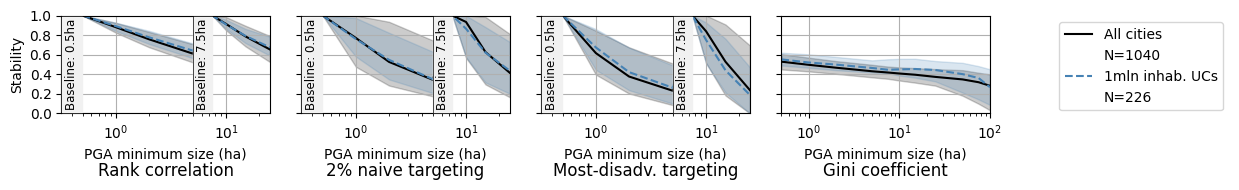

In [4]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25]
fig=plt.figure(figsize=(12.5,2))

tmp1=df.copy()
VAR='Ktau_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_ylabel('Stability')
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title("Rank correlation", y=0, pad=-35, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()
    
tmp1=df.copy()
VAR='Naive2_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,2)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('2% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

tmp1=df.copy()
VAR='MostDisadvantaged3_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,3)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('Most-disadv. targeting',y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

tmp1=df.copy()
VAR='Gini_MD'
bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75, 100]
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))


ax=plt.subplot(1,5,4)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('Gini coefficient', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_xlim([0.5,100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xscale('log')


ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='dashed', c='steelblue'),
           lines.Line2D([0], [0],  ls='solid', c='white'),],
          ['All cities', 'N=1040', '1mln inhab. UCs', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_all_manybaselines.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_all_manybaselines.png", bbox_inches='tight', dpi=300)

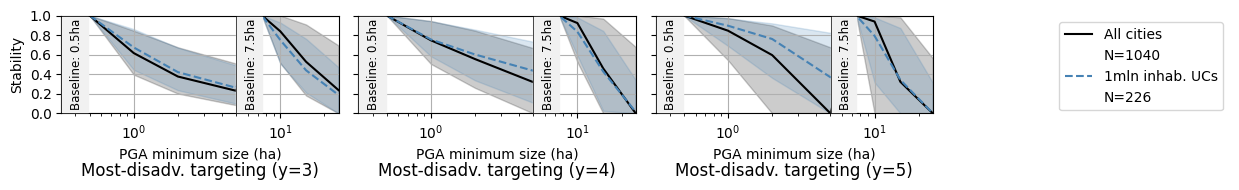

In [5]:
#All, alternative targeting
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25]
fig=plt.figure(figsize=(12.5,2))

tmp1=df.copy()
VAR='MostDisadvantaged3_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,4,1)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_ylabel('Stability')
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title("Most-disadv. targeting (y=3)", y=0, pad=-35, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()
    
tmp1=df.copy()
VAR='MostDisadvantaged_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,4,2)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('Most-disadv. targeting (y=4)', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

tmp1=df.copy()
VAR='MostDisadvantaged5_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,4,3)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('Most-disadv. targeting (y=5)',y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

tmp1=df.copy()
VAR='Gini_MD'
bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75, 100]
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))


ax=plt.subplot(1,4,4)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='dashed', c='steelblue'),
           lines.Line2D([0], [0],  ls='solid', c='white'),],
          ['All cities', 'N=1040', '1mln inhab. UCs', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_all_manybaselines_Mostdisad_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_all_manybaselines_Mostdisad_sensitivity.png", bbox_inches='tight', dpi=300)

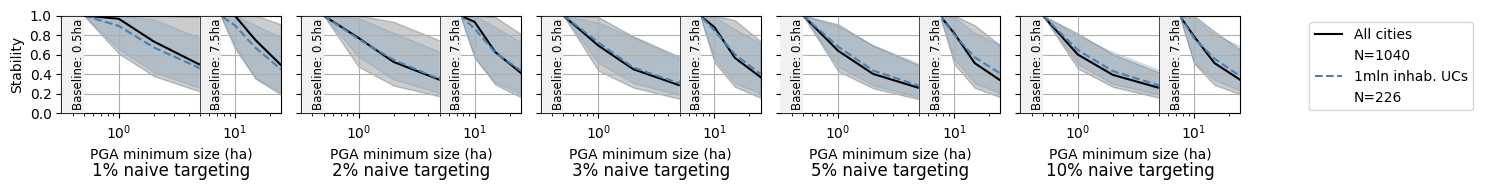

In [6]:
#All, alternative targeting
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25]
fig=plt.figure(figsize=(15,2))

tmp1=df.copy()
VAR='Naive1_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,1)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_ylabel('Stability')
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title("1% naive targeting", y=0, pad=-35, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()
    
tmp1=df.copy()
VAR='Naive2_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,2)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('2% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

tmp1=df.copy()
VAR='Naive3_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,3)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('3% naive targeting',y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

tmp1=df.copy()
VAR='Naive5_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,4)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('5% naive targeting',y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


tmp1=df.copy()
VAR='Naive10_MD'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,5)
ax.grid()
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('10% naive targeting',y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='dashed', c='steelblue'),
           lines.Line2D([0], [0],  ls='solid', c='white'),],
          ['All cities', 'N=1040', '1mln inhab. UCs', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_all_manybaselines_Naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_all_manybaselines_Naive_sensitivity.png", bbox_inches='tight', dpi=300)

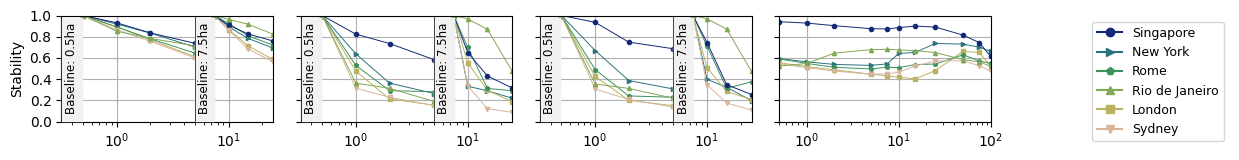

In [7]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25]
selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={'Singapore':cmap(0.1), 'New_York':cmap(0.25), 'Rome':cmap(0.40), 'Rio_de_Janeiro':cmap(0.57), 'London':cmap(0.72), 'Sydney':cmap(0.87)}

fig=plt.figure(figsize=(12.5,1.7))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
ax.set_ylabel('Stability')
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title("Rank correlation")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Ktau_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

ax=plt.subplot(1,5,2)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title('2% naive targeting')
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive2_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.329,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


ax=plt.subplot(1,5,3)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title('Most-Disadv. targeting')
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['MostDisadvantaged3_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.329,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

ax=plt.subplot(1,5,4)
bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50, 75, 100]
ax.grid()
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Gini_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xticks(bins_parksize)
ax.set_xticklabels(bins_parksize)
ax.set_ylim([0,1])
ax.set_xlim([0.5,100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xscale('log')


ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([
           lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          ['Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines.png", bbox_inches='tight', dpi=300)

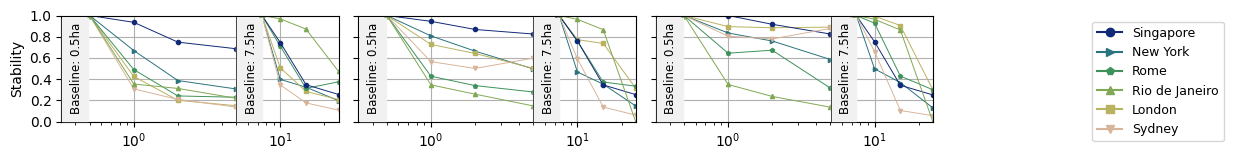

In [8]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25]
selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={'Singapore':cmap(0.1), 'New_York':cmap(0.25), 'Rome':cmap(0.40), 'Rio_de_Janeiro':cmap(0.57), 'London':cmap(0.72), 'Sydney':cmap(0.87)}

fig=plt.figure(figsize=(12.5,1.7))
    
ax=plt.subplot(1,4,1)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
ax.set_ylabel('Stability')
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title("Rank correlation")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['MostDisadvantaged3_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

ax=plt.subplot(1,4,2)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title('2% naive targeting')
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['MostDisadvantaged_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.329,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


ax=plt.subplot(1,4,3)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title('Most-Disadv. targeting')
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['MostDisadvantaged5_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.329,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='right', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


ax=plt.subplot(1,4,4)
ax.axis('off')
ax.legend([
           lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          ['Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines_Mostdisadv_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines_Mostdisadv_sensitivity.png", bbox_inches='tight', dpi=300)

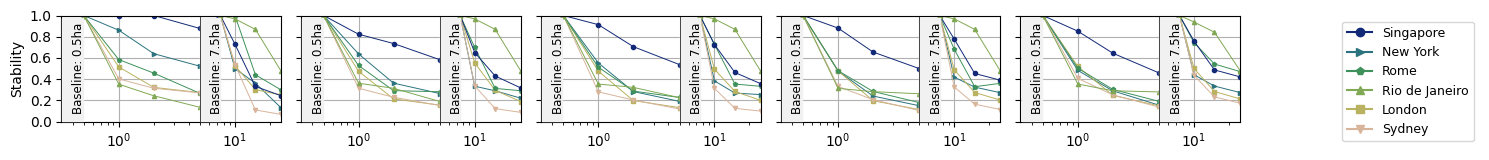

In [9]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25]
selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={'Singapore':cmap(0.1), 'New_York':cmap(0.25), 'Rome':cmap(0.40), 'Rio_de_Janeiro':cmap(0.57), 'London':cmap(0.72), 'Sydney':cmap(0.87)}

fig=plt.figure(figsize=(15,1.7))

ax=plt.subplot(1,6,1)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
ax.set_ylabel('Stability')
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title("Rank correlation")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive1_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


ax=plt.subplot(1,6,2)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title("Rank correlation")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive2_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

    
ax=plt.subplot(1,6,3)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title("Rank correlation")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive3_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.325,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()

ax=plt.subplot(1,6,4)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title('2% naive targeting')
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive5_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.329,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


ax=plt.subplot(1,6,5)
ax.grid()
ax.set_xticks(bins_parksize)
ax.set_xticklabels(['']*len(bins_parksize))
#ax.set_xlabel('PGA minimum size (ha)')
#ax.set_title('Most-Disadv. targeting')
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive10_MD'].values[0][:len(bins_parksize)]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_ylim([0,1])
ax.fill_between([5.01,7.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.fill_between([0.329,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 7, 0.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.45, 0.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.32,25])
ax.set_xscale('log')
ax.axis()


ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([
           lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          ['Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines_naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines_naive_sensitivity.png", bbox_inches='tight', dpi=300)

/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/tljh/user/lib/python3.9/site-packag

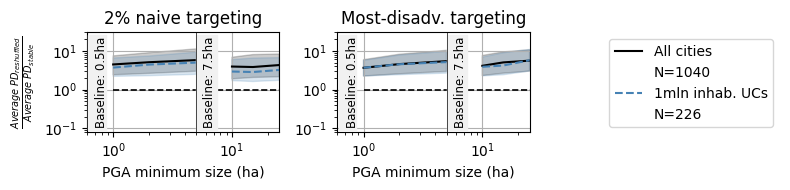

In [21]:
### Relative density of areas
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25]
selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={'Singapore':cmap(0.1), 'New_York':cmap(0.25), 'Rome':cmap(0.40), 'Rio_de_Janeiro':cmap(0.57), 'London':cmap(0.72), 'Sydney':cmap(0.87)}

fig=plt.figure(figsize=(8,2))

ax=plt.subplot(1,3,1)
tmp1=df.copy()
VAR1='Naive2_MD_densitystable'
VAR2='Naive2_MD_densityunstable'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR1}_{i}']=tmp1[f'{VAR1}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
    tmp1[f'{VAR2}_{i}']=tmp1[f'{VAR2}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
    tmp1[f'RATIO_{i}']=tmp1.apply(lambda x: x[f"{VAR2}_{i}"]/x[f"{VAR1}_{i}"] if x[f"{VAR1}_{i}"]>0 else np.nan, axis=1)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 

for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'RATIO_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'RATIO_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'RATIO_{i}'], 75))

    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'RATIO_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'RATIO_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'RATIO_{i}'], 75))

ax.grid()
ax.set_xticks(bins_parksize[1:])
ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.plot([1,5], [1,1], color='black', linestyle='dashed', linewidth=1.2)
ax.plot([7.5,25], [1,1], color='black', linestyle='dashed', linewidth=1.2)
ax.set_yscale('log')
ax.fill_between([5.01,7.49], [0.09,0.09], [25,25], color='#f1f1f1', zorder=4)
ax.fill_between([0.87,0.62], [0.09,0.09], [25,25], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 6.5, 1.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.8, 1.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.6,25])
ax.set_ylim([0.08,30])
ax.set_xscale('log')
ax.set_xlabel('PGA minimum size (ha)')
ax.set_ylabel(r'$\frac{Average \; PD_{reshuffled}}{Average \; PD_{stable}}$')
ax.set_title('2% naive targeting', loc='center')
ax.axis()

ax=plt.subplot(1,3,2)
tmp1=df.copy()
VAR1='MostDisadvantaged3_MD_densitystable'
VAR2='MostDisadvantaged3_MD_densityunstable'
for indi,i in enumerate(bins_parksize):
    tmp1[f'{VAR1}_{i}']=tmp1[f'{VAR1}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
    tmp1[f'{VAR2}_{i}']=tmp1[f'{VAR2}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
    tmp1[f'RATIO_{i}']=tmp1.apply(lambda x: x[f"{VAR2}_{i}"]/x[f"{VAR1}_{i}"] if x[f"{VAR1}_{i}"]>0 else np.nan, axis=1)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 

for indi,i in enumerate(bins_parksize):
    allcities_median.append(tmp1[f'RATIO_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'RATIO_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'RATIO_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'RATIO_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'RATIO_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'RATIO_{i}'], 75))

ax.grid()
ax.set_xticks(bins_parksize[1:])

ax.plot(bins_parksize, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')

ax.fill_between(bins_parksize, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.plot([1,5], [1,1], color='black', linestyle='dashed', linewidth=1.2)
ax.plot([7.5,25], [1,1], color='black', linestyle='dashed', linewidth=1.2)
ax.set_yscale('log')
ax.fill_between([5.01,7.49], [0.09,0.09], [25,25], color='#f1f1f1', zorder=4)
ax.fill_between([0.87,0.62], [0.09,0.09], [25, 25], color='#f1f1f1', zorder=4)
ax.axvline(5.01, 0, 1, color='black', zorder=5, linewidth=0.5)
ax.text( 6.5, 1.5,'Baseline: 7.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.text( 0.8, 1.5,'Baseline: 0.5ha', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.set_xlim([0.6,25])
ax.set_ylim([0.08,30])
ax.set_xscale('log')
#ax.set_ylabel(r'$\frac{Density \; reshuffled \; population}{Density \; stable \; population}$')
ax.axis()
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('Most-disadv. targeting', loc='center')
#ax.set_ylabel(r'$\frac{Density \; reshuffled \; population}{Density \; stable \; population}$')
ax.axis()

 

ax=plt.subplot(1,3,3)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='dashed', c='steelblue'),
           lines.Line2D([0], [0],  ls='solid', c='white'),],
          ['All cities', 'N=1040', '1mln inhab. UCs', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()



plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines_densitypop.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_selectedcities_manybaselines_densitypop.png", bbox_inches='tight', dpi=300)

In [11]:
from matplotlib.colors import Normalize
def stable_naive_targeting_plot(df, var1, x): #For worst is people leaving
    
    tmp=df.copy()
    for_index1=sorted(tmp[var1].unique())
    cutoff1=[i for ind,i in enumerate(for_index1) if i>=x and (for_index1[ind-1]<x or ind==0)][0]
    del for_index1
    tmp['target']=0
    tmp.loc[tmp[var1]<=cutoff1, 'target']=1    
    return tmp[['target', 'id', 'population','geom']]

def stable_mostdisadvantaged_targeting_plot(df, var1, index_type, factor=4): #For worst is people leaving
    
    tmp=df.copy()
    #Adjustment for non computed cells, only needed for minimum distance
    if index_type=='min_dist':
        for var in [var1]:
            tmp.loc[tmp[var]<0, var]=tmp[var].max()+tmp[var].std()
        
    if index_type=='min_dist':
        cutoff1=factor*sum(tmp[var1]*tmp['population'])/tmp['population'].sum()
    else:
        cutoff1=0
        
    tmp['target']=0
    if index_type=='min_dist':  
        tmp.loc[tmp[var1]>cutoff1, 'target']=1 
    else: 
        tmp.loc[tmp[var1]<=cutoff1, 'target']=1 
    return tmp[['target', 'id','population', 'geom']]


1it [00:39, 39.82s/it]


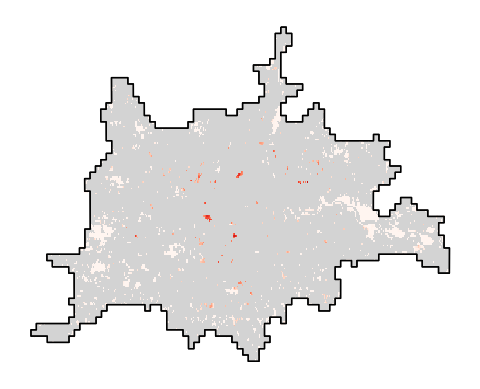

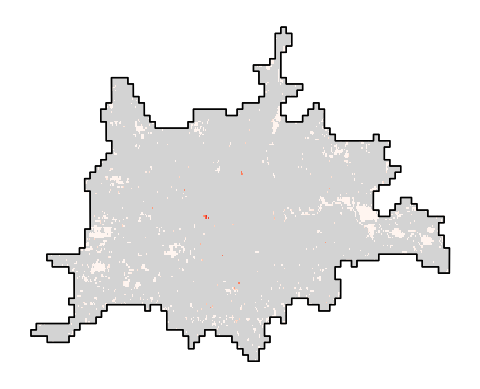

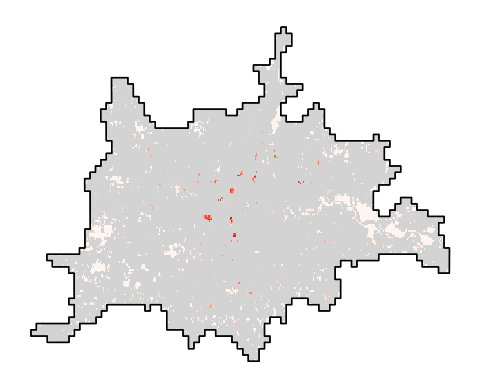

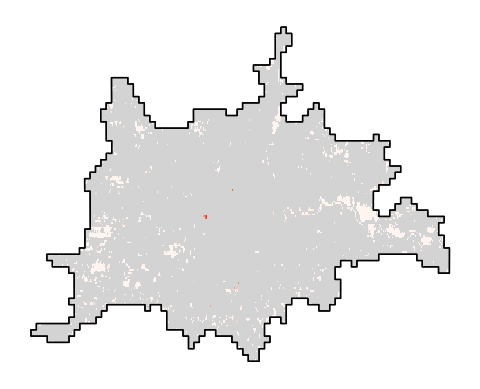

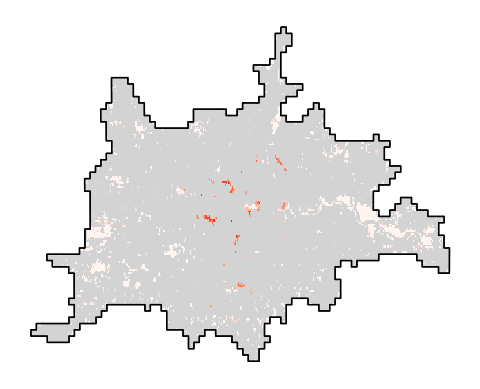

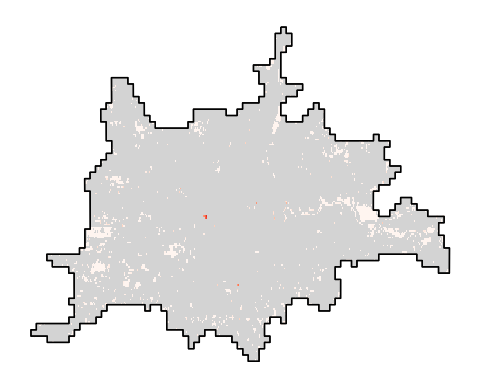

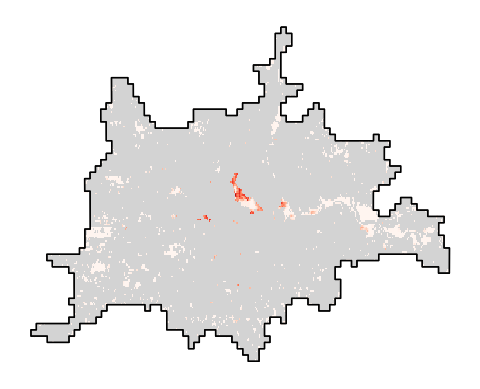

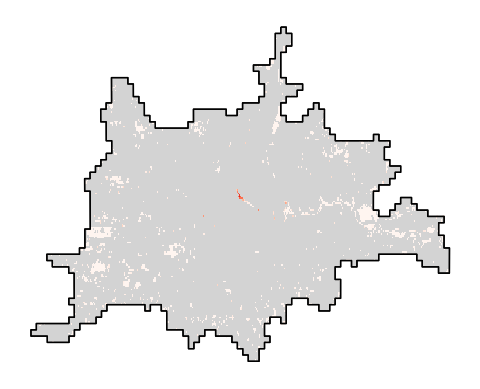

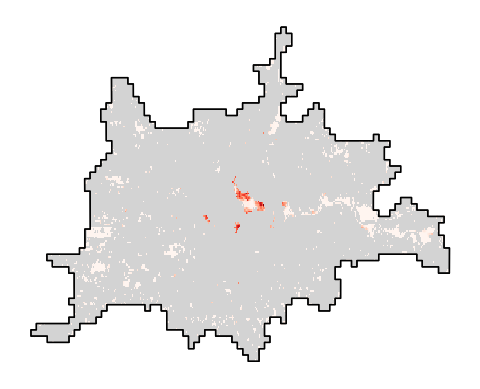

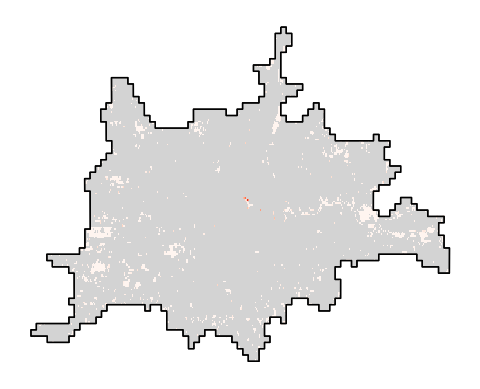

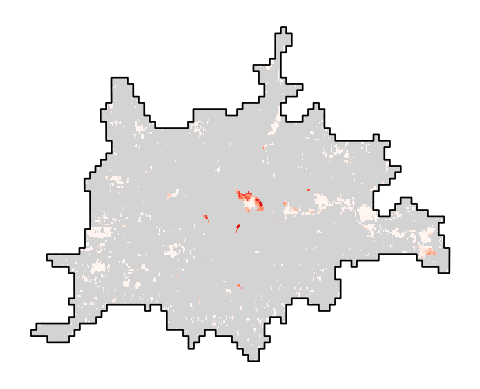

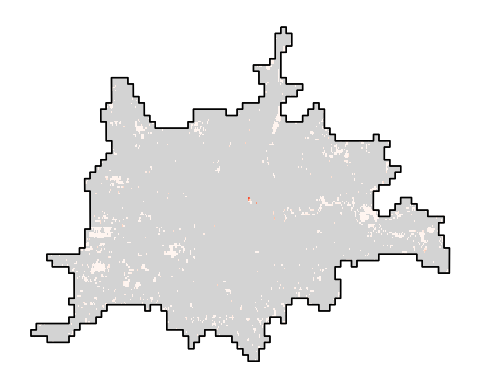

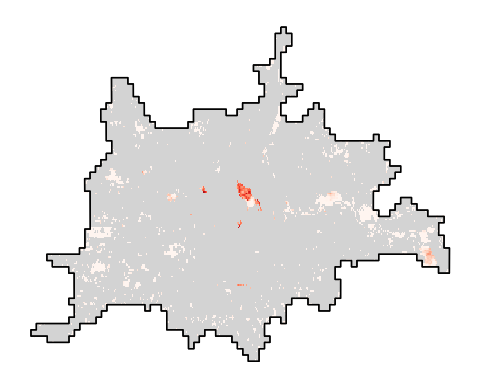

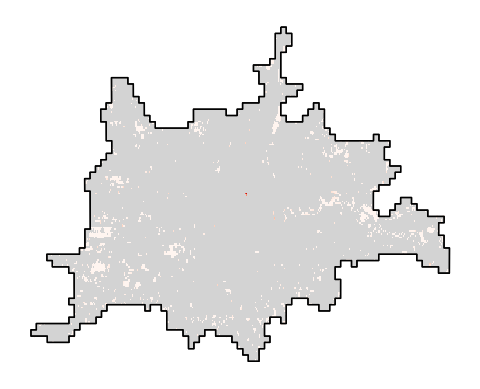

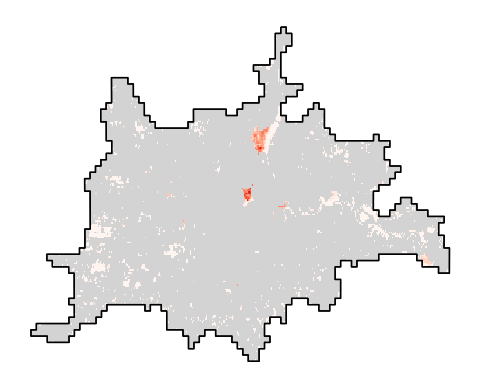

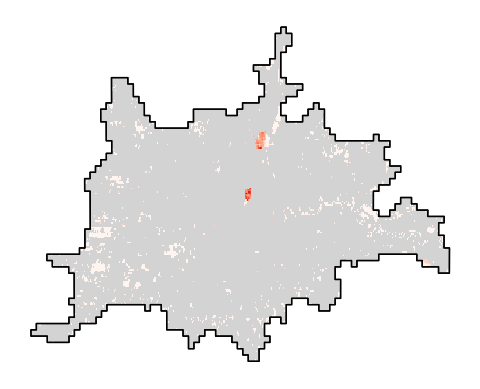

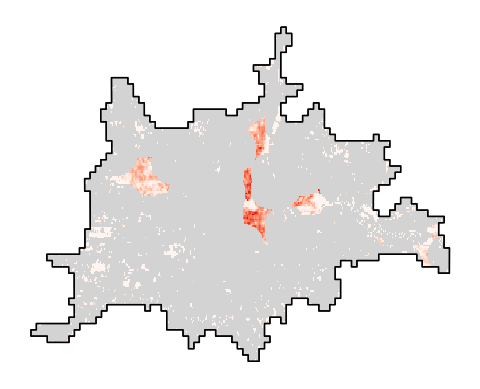

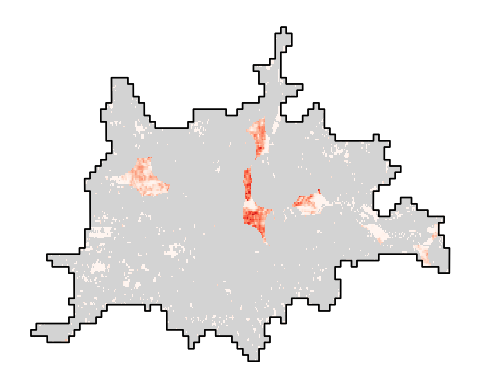

In [12]:
#Plot for the city of london the rearranement of the ranking 
bins_parksize=[0.5, 1, 2, 5, 7.5, 10, 15, 25, 50]

for ind_city,city in tqdm(enumerate(['London'])):
    
    city_boundary=query4cityboundary(city, db_params)
    df_formap=pd.read_csv(f"{PATH}/indices/{city}_stability_allindices.csv")
    pop=query4grid_unmasked(f"{city}", db_params)
    n_rows=pop['y'].max()
    if 'id' not in df_formap.columns:
        df_formap['id']=df_formap.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
 
    pop['id']=pop.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    inbound=query4grid(city, db_params)
    inbound=inbound[inbound['inbound']==1]
    inbound['id']=inbound.apply(lambda x: x['y']+n_rows*(x['x']-1), axis=1)
    df_formap=df_formap[df_formap['id'].isin(list(inbound['id']))]
    df_formap=pd.merge(df_formap, pop, on=['id'], how='left')
    
    for i in bins_parksize:
        tmp=stable_naive_targeting_plot(df_formap, f'BetterThanEqual_min_dist_{i}', 0.02)
        tmp=gpd.GeoDataFrame(tmp, geometry='geom', crs='EPSG:4326')
        fig=plt.figure()
        ax=plt.subplot(111)
        city_boundary.boundary.plot(linewidth=1, color='black', ax=ax)
        city_boundary.plot(color='lightgrey', ax=ax)
        tmp[tmp['target']>0].plot('population', cmap='Reds', ax=ax, norm=Normalize(vmin=0, vmax=df_formap['population'].max()))
        city_boundary.boundary.plot(linewidth=1, color='black', ax=ax)
        ax.axis('off')  
        plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_{city}_Naive_{i}.pdf", bbox_inches='tight', dpi=300,facecolor=None)
        plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_{city}_Naive_{i}.png", bbox_inches='tight', dpi=300,facecolor=None)
        
        
        tmp=stable_mostdisadvantaged_targeting_plot(df_formap, f'min_dist_{i}', 'min_dist')
        tmp=gpd.GeoDataFrame(tmp, geometry='geom', crs='EPSG:4326')
        fig=plt.figure()
        ax=plt.subplot(111)
        city_boundary.boundary.plot(linewidth=1, color='black', ax=ax)
        city_boundary.plot(color='lightgrey', ax=ax)
        tmp[tmp['target']>0].plot('population', cmap='Reds', ax=ax, norm=Normalize(vmin=0, vmax=df_formap['population'].max()))
        city_boundary.boundary.plot(linewidth=1, color='black', ax=ax)
        ax.axis('off') 
        plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_{city}_MostDis_{i}.pdf", bbox_inches='tight', dpi=300,facecolor=None)
        plt.savefig(f"{PATH}/Figures/Stability/Stability_MD_{city}_MostDis_{i}.png", bbox_inches='tight', dpi=300,facecolor=None)

### Exposure (first bin baseline)

In [13]:
### Identify large cities with high or low relative maximum turnover (among cities with more than 1m inhabitants)
df=pd.read_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_firstbin.csv")
for var in list(set(df.columns) - set(['city'])):
    df[var]=df[var].apply(lambda x: literal_eval(x.replace('nan', '-9')) )
df_pop=pd.read_csv(f"{PATH}/output/summaryIndices/summary_cities.csv")
df=pd.merge(df, df_pop[['city','population']], on=['city'], how='left')

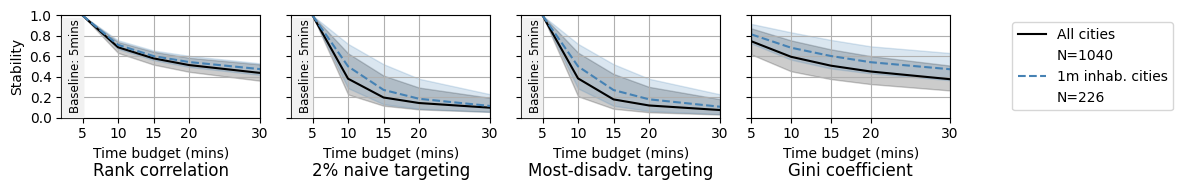

In [14]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_timebudget=[5, 10, 15, 20, 30]
fig=plt.figure(figsize=(12,2))

tmp1=df.copy()
VAR='Ktau_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_ylabel('Stability')
ax.set_xlabel('Time budget (mins)')
ax.set_title("Rank correlation", y=0, pad=-32, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.set_xlim([2, 30])
ax.fill_between([2.05,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

  
tmp1=df.copy()
VAR='Naive2_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,2)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('2% naive targeting', y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([2, 30])
ax.fill_between([2.05,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

tmp1=df.copy()
VAR='MostDisadvantaged_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,3)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('Most-disadv. targeting',y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([2, 30])
ax.fill_between([2.05,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

tmp1=df.copy()
VAR='Gini_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))


ax=plt.subplot(1,5,4)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('Gini coefficient', y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([5, 30])

ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='--', c='steelblue'),
          lines.Line2D([0], [0],  ls='solid', c='white')],
          ['All cities', 'N=1040', '1m inhab. cities', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_all_firstbin.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_all_firstbin.png", bbox_inches='tight', dpi=300)

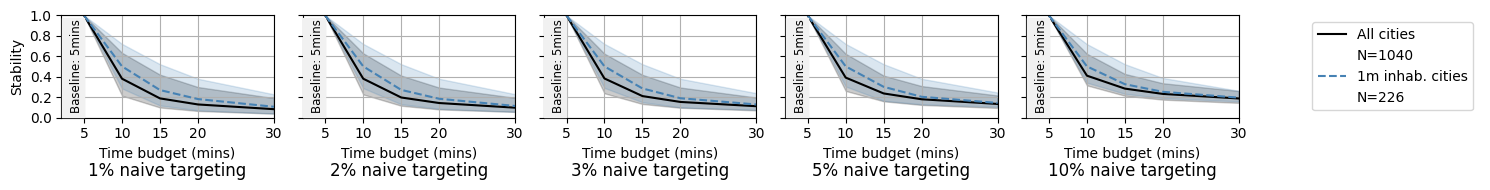

In [15]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_timebudget=[5, 10, 15, 20, 30]
fig=plt.figure(figsize=(15,2))

tmp1=df.copy()
VAR='Naive1_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,1)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('1% naive targeting', y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel('Stability')
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

  
tmp1=df.copy()
VAR='Naive2_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,2)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('2% naive targeting', y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

tmp1=df.copy()
VAR='Naive3_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,3)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('3% naive targeting', y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

tmp1=df.copy()
VAR='Naive5_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,4)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('5% naive targeting', y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

tmp1=df.copy()
VAR='Naive10_EXP'
for indi,i in enumerate(bins_timebudget):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,5)
ax.grid()
ax.plot(bins_timebudget, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(bins_timebudget)
ax.set_xlabel('Time budget (mins)')
ax.set_title('10% naive targeting', y=0, pad=-32, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()


ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='--', c='steelblue'),
          lines.Line2D([0], [0],  ls='solid', c='white')],
          ['All cities', 'N=1040', '1m inhab. cities', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_all_firstbin_naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_all_firstbin_naive_sensitivity.png", bbox_inches='tight', dpi=300)

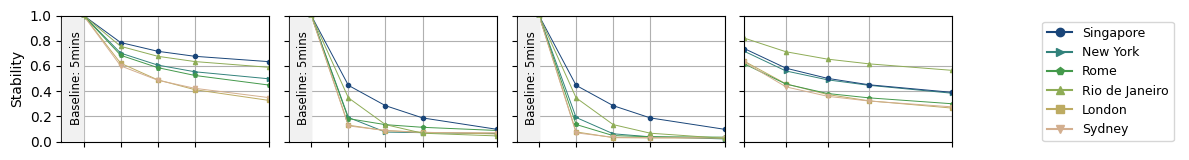

In [20]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_timebudget=[5, 10, 15, 20, 30]
selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={ 'Singapore':cmap(0.15), 'New_York':cmap(0.3), 'Rome':cmap(0.45), 'Rio_de_Janeiro':cmap(0.6), 'London':cmap(0.75), 'Sydney':cmap(0.85)}

fig=plt.figure(figsize=(12,1.7))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylabel('Stability')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Ktau_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()
    
ax=plt.subplot(1,5,2)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive2_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()  

ax=plt.subplot(1,5,3)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['MostDisadvantaged_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.12,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()
    
ax=plt.subplot(1,5,4)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Gini_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([5, 30])


ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          [ 'Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_selectedcities_firstbin.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_selectedcities_firstbin.png", bbox_inches='tight', dpi=300)

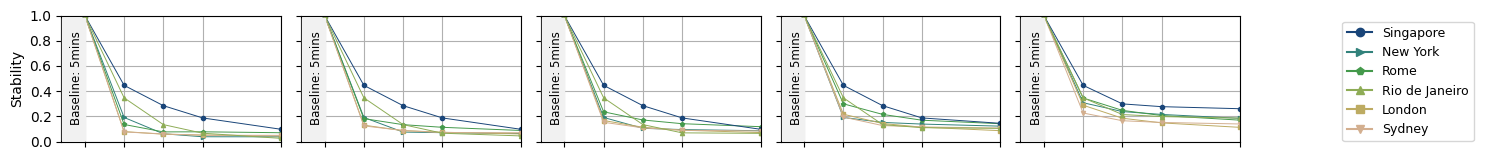

In [21]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_timebudget=[5, 10, 15, 20, 30]
selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={ 'Singapore':cmap(0.15), 'New_York':cmap(0.3), 'Rome':cmap(0.45), 'Rio_de_Janeiro':cmap(0.6), 'London':cmap(0.75), 'Sydney':cmap(0.85)}

fig=plt.figure(figsize=(15,1.7))
    
ax=plt.subplot(1,6,1)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylabel('Stability')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive1_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()
    
ax=plt.subplot(1,6,2)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive2_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.1,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()  

ax=plt.subplot(1,6,3)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive3_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.12,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()
    
ax=plt.subplot(1,6,4)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive5_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.12,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()

ax=plt.subplot(1,6,5)
ax.grid()
ax.set_xticks(bins_timebudget)
ax.set_xticklabels(['']*len(bins_timebudget))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=df[df['city']==city]['Naive10_EXP'].values[0][:]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([2, 30])
ax.fill_between([2.12,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 4, 0.5,'Baseline: 5mins', rotation=90, color='black', va='center', ha='center', zorder=5, fontsize=8.5)
ax.axis()


ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          [ 'Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_selectedcities_firstbin_naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_EXP_selectedcities_firstbin_naive_sensitivity.png", bbox_inches='tight', dpi=300)

### Per-person (first bin)

In [4]:
### Identify large cities with high or low relative maximum turnover (among cities with more than 1m inhabitants)
df=pd.read_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_firstbin.csv")
for var in list(set(df.columns) - set(['city'])):
    df[var]=df[var].apply(lambda x: literal_eval(x.replace('nan', '-9')) )
df_pop=pd.read_csv(f"{PATH}/output/summaryIndices/summary_cities.csv")
df=pd.merge(df, df_pop[['city','population']], on=['city'], how='left')

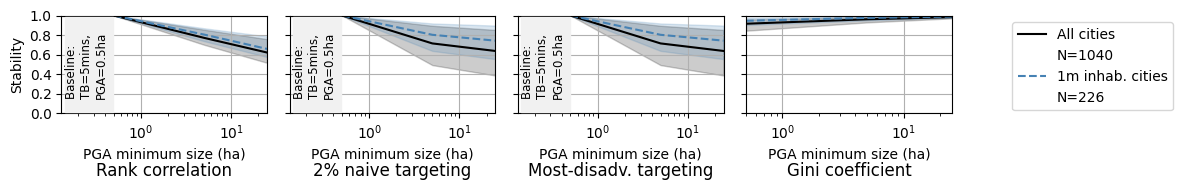

In [34]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize_short=[0.5, 5, 25]
bins_timebudget_short=[5, 15, 30]
fig=plt.figure(figsize=(12,2))

tmp1=df.copy()
VAR='Ktau_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_ylabel('Stability')
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title("Rank correlation", y=0, pad=-35, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


  
tmp1=df.copy()
VAR='Naive2_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,2)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('2% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')

tmp1=df.copy()
VAR='MostDisadvantaged_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,3)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('Most-disadv. targeting',y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


tmp1=df.copy()
VAR='Gini_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))


ax=plt.subplot(1,5,4)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('Gini coefficient', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xscale('log')
ax.set_xlim([0.5, 25])


ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='--', c='steelblue'),
          lines.Line2D([0], [0],  ls='solid', c='white')],
          ['All cities', 'N=1040', '1m inhab. cities', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_PGAsize.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_PGAsize.png", bbox_inches='tight', dpi=300)

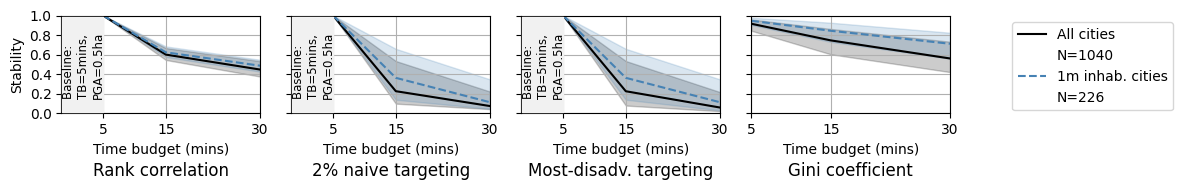

In [39]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize_short=[0.5, 5, 25]
bins_timebudget_short=[5, 15, 30]
fig=plt.figure(figsize=(12,2))

tmp1=df.copy()
VAR='Ktau_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_ylabel('Stability')
ax.set_xlabel('Time budget (mins)')
ax.set_title("Rank correlation", y=0, pad=-35, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.set_xlim([-1.65, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()

  
tmp1=df.copy()
VAR='Naive2_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,2)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_xlabel('Time budget (mins)')
ax.set_title('2% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([-1.65, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()


tmp1=df.copy()
VAR='MostDisadvantaged_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,5,3)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_xlabel('Time budget (mins)')
ax.set_title('Most-disadv. targeting',y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([-1.65, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()


tmp1=df.copy()
VAR='Gini_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))


ax=plt.subplot(1,5,4)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_xlabel('Time budget (mins)')
ax.set_title('Gini coefficient', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([5, 30])


ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='--', c='steelblue'),
          lines.Line2D([0], [0],  ls='solid', c='white')],
          ['All cities', 'N=1040', '1m inhab. cities', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_TB.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_TB.png", bbox_inches='tight', dpi=300)

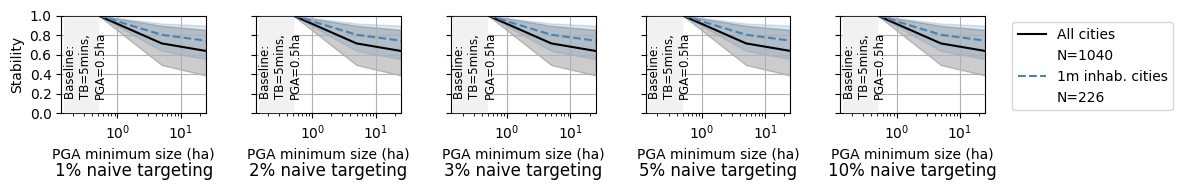

In [40]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize_short=[0.5, 5, 25]
bins_timebudget_short=[5, 15, 30]
fig=plt.figure(figsize=(12,2))

tmp1=df.copy()
VAR='Naive1_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,1)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_ylabel('Stability')
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('1% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


  
tmp1=df.copy()
VAR='Naive2_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,2)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('2% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')

 
tmp1=df.copy()
VAR='Naive3_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,3)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('3% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


 
tmp1=df.copy()
VAR='Naive5_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,4)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('5% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')

 
tmp1=df.copy()
VAR='Naive10_PP'
for indi,i in enumerate(bins_parksize_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi*len(bins_timebudget_short)] if x[indi*len(bins_timebudget_short)]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_parksize_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,5)
ax.grid()
ax.plot(bins_parksize_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_parksize_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_parksize_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_parksize_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(bins_parksize_short)
ax.set_xlabel('PGA minimum size (ha)')
ax.set_title('10% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')



ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='--', c='steelblue'),
          lines.Line2D([0], [0],  ls='solid', c='white')],
          ['All cities', 'N=1040', '1m inhab. cities', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_PGAsize_naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_PGAsize_naive_sensitivity.png", bbox_inches='tight', dpi=300)

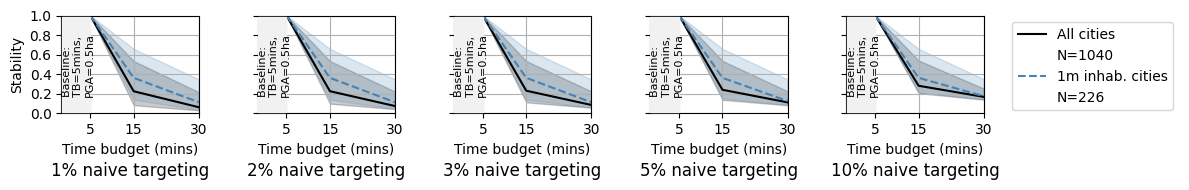

In [49]:
import matplotlib.pyplot as plt
from matplotlib import lines

bins_parksize_short=[0.5, 5, 25]
bins_timebudget_short=[5, 15, 30]
fig=plt.figure(figsize=(12,2))

tmp1=df.copy()
VAR='Naive1_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[]
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,1)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_ylabel('Stability')
ax.set_xlabel('Time budget (mins)')
ax.set_title('1% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

  
tmp1=df.copy()
VAR='Naive2_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,2)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_xlabel('Time budget (mins)')
ax.set_title('2% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

 
tmp1=df.copy()
VAR='Naive3_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,3)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_xlabel('Time budget (mins)')
ax.set_title('3% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([-1.71, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

 
tmp1=df.copy()
VAR='Naive5_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,4)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_xlabel('Time budget (mins)')
ax.set_title('5% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([-1.71, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

 
tmp1=df.copy()
VAR='Naive10_PP'
for indi,i in enumerate(bins_timebudget_short):
    tmp1[f'{VAR}_{i}']=tmp1[f'{VAR}'].apply(lambda x: x[indi] if x[indi]!=-9 else np.nan)
allcities_median=[] 
above1millioncities_median=[] 
allcities_25=[] 
above1millioncities_25=[] 
allcities_75=[] 
above1millioncities_75=[] 
for indi,i in enumerate(bins_timebudget_short):
    allcities_median.append(tmp1[f'{VAR}_{i}'].median())
    allcities_25.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 25))
    allcities_75.append(np.nanpercentile(tmp1[f'{VAR}_{i}'], 75))
    above1millioncities_median.append(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'].median())
    above1millioncities_25.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 25))
    above1millioncities_75.append(np.nanpercentile(tmp1[tmp1['population']>1000000][f'{VAR}_{i}'], 75))
    
ax=plt.subplot(1,6,5)
ax.grid()
ax.plot(bins_timebudget_short, allcities_median, alpha=1, color='black', linestyle='solid')
ax.fill_between(bins_timebudget_short, allcities_25, allcities_75, alpha=0.2, color='black')
ax.plot(bins_timebudget_short, above1millioncities_median, alpha=1, color='steelblue', linestyle='--')
ax.fill_between(bins_timebudget_short, above1millioncities_25, above1millioncities_75, alpha=0.2, color='steelblue')
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(bins_timebudget_short)
ax.set_xlabel('Time budget (mins)')
ax.set_title('10% naive targeting', y=0, pad=-35, verticalalignment="top")
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()




ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', c='black'),
           lines.Line2D([0], [0],  ls='solid', c='white'),
           lines.Line2D([0], [0],  ls='--', c='steelblue'),
          lines.Line2D([0], [0],  ls='solid', c='white')],
          ['All cities', 'N=1040', '1m inhab. cities', f"N={len(df[df['population']>1000000])}"], fontsize=10)
plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_TB_naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_all_firstbin_TB_naive_sensitivity.png", bbox_inches='tight', dpi=300)

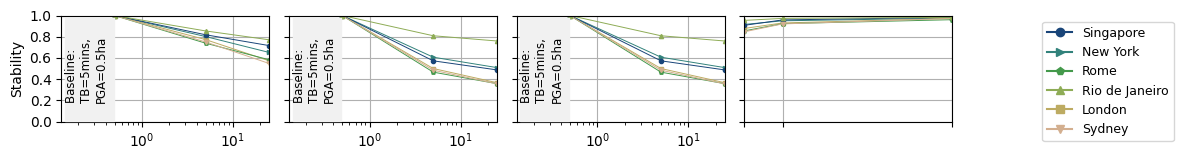

In [51]:
import matplotlib.pyplot as plt
from matplotlib import lines

selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={ 'Singapore':cmap(0.15), 'New_York':cmap(0.3), 'Rome':cmap(0.45), 'Rio_de_Janeiro':cmap(0.6), 'London':cmap(0.75), 'Sydney':cmap(0.85)}

fig=plt.figure(figsize=(12,1.7))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylabel('Stability')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Ktau_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')

    
ax=plt.subplot(1,5,2)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive2_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


ax=plt.subplot(1,5,3)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['MostDisadvantaged_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')

    
ax=plt.subplot(1,5,4)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Gini_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([0.5, 25])


ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          [ 'Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_PGAsize.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_PGAsize.png", bbox_inches='tight', dpi=300)

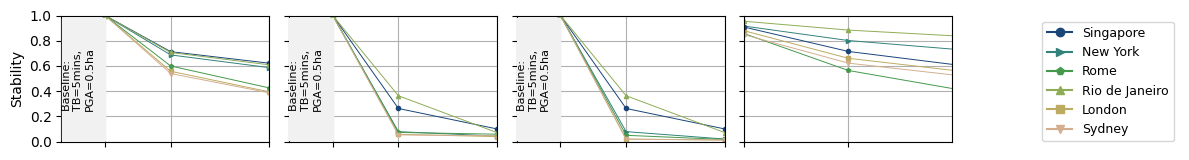

In [53]:
import matplotlib.pyplot as plt
from matplotlib import lines

selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={ 'Singapore':cmap(0.15), 'New_York':cmap(0.3), 'Rome':cmap(0.45), 'Rio_de_Janeiro':cmap(0.6), 'London':cmap(0.75), 'Sydney':cmap(0.85)}

fig=plt.figure(figsize=(12,1.7))
    
ax=plt.subplot(1,5,1)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylabel('Stability')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Ktau_PP'].values[0][i] for i in [0, 1, 2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

    
ax=plt.subplot(1,5,2)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive2_PP'].values[0][i] for i in [0, 1,2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

ax=plt.subplot(1,5,3)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['MostDisadvantaged_PP'].values[0][i] for i in [0, 1, 2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

    
ax=plt.subplot(1,5,4)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Gini_PP'].values[0][i] for i in [0, 1, 2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([5, 25])


ax=plt.subplot(1,5,5)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          [ 'Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_TB.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_TB.png", bbox_inches='tight', dpi=300)

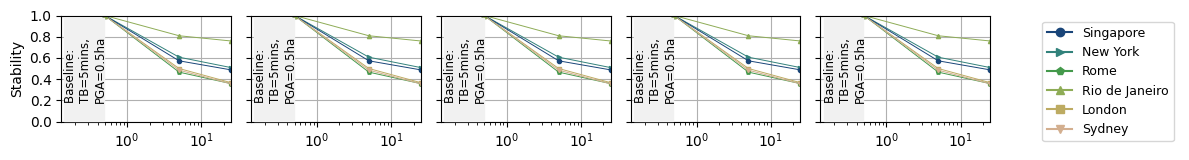

In [54]:
import matplotlib.pyplot as plt
from matplotlib import lines

selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={ 'Singapore':cmap(0.15), 'New_York':cmap(0.3), 'Rome':cmap(0.45), 'Rio_de_Janeiro':cmap(0.6), 'London':cmap(0.75), 'Sydney':cmap(0.85)}

fig=plt.figure(figsize=(12,1.7))
    
ax=plt.subplot(1,6,1)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylabel('Stability')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive1_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')

    
ax=plt.subplot(1,6,2)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive2_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


ax=plt.subplot(1,6,3)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive3_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')

    
ax=plt.subplot(1,6,4)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive5_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


ax=plt.subplot(1,6,5)
ax.grid()
ax.set_xticks(bins_parksize_short)
ax.set_xticklabels(['']*len(bins_parksize_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive10_PP'].values[0][i] for i in [0, 3, 6]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_parksize_short, t_val, alpha=1, marker=marker_list[city],markersize=3, linewidth=0.7,color=color_list[city])
ax.set_xlim([0.13, 25])
ax.fill_between([0.143,0.49], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( 0.143, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8.5)
ax.axis()
ax.set_xscale('log')


ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          [ 'Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_PGAsize_naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_PGAsize_naive_sensitivity.png", bbox_inches='tight', dpi=300)

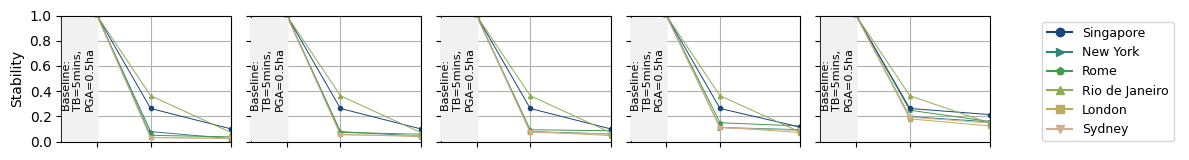

In [55]:
import matplotlib.pyplot as plt
from matplotlib import lines

selected_cities=['New_York', 'London',  'Rome', 'Singapore', 'Sydney','Rio_de_Janeiro']
marker_list={'Singapore':'o', 'New_York':'>', 'Rome':'p', 'Rio_de_Janeiro':'^', 'London':'s', 'Sydney':'v'}
color_list={ 'Singapore':cmap(0.15), 'New_York':cmap(0.3), 'Rome':cmap(0.45), 'Rio_de_Janeiro':cmap(0.6), 'London':cmap(0.75), 'Sydney':cmap(0.85)}

fig=plt.figure(figsize=(12,1.7))
    
ax=plt.subplot(1,6,1)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylabel('Stability')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive1_PP'].values[0][i] for i in [0, 1, 2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1,marker=marker_list[city], markersize=3,linewidth=0.7, color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

    
ax=plt.subplot(1,6,2)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive2_PP'].values[0][i] for i in [0, 1,2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

ax=plt.subplot(1,6,3)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive3_PP'].values[0][i] for i in [0, 1,2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

ax=plt.subplot(1,6,4)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive5_PP'].values[0][i] for i in [0, 1,2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()

ax=plt.subplot(1,6,5)
ax.grid()
ax.set_xticks(bins_timebudget_short)
ax.set_xticklabels(['']*len(bins_timebudget_short))
ax.set_ylim([0,1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['', '', '', '', '', ''])
for indc,city in enumerate(selected_cities):
    t_val=[ df[df['city']==city]['Naive10_PP'].values[0][i] for i in [0, 1,2]]
    t_val=[i if i!=-9 else np.nan for i in t_val]
    ax.plot(bins_timebudget_short, t_val, alpha=1,marker=marker_list[city],markersize=3, linewidth=0.7, color=color_list[city])
ax.set_xlim([-1.67, 30])
ax.fill_between([-1.6,4.99], [0.01,0.01], [0.98,0.98], color='#f1f1f1', zorder=4)
ax.text( -1.6, 0.5,'Baseline: \nTB=5mins, \nPGA=0.5ha', rotation=90, color='black', va='center', ha='left', zorder=5, fontsize=8)
ax.axis()



ax=plt.subplot(1,6,6)
ax.axis('off')
ax.legend([lines.Line2D([0], [0],  ls='solid', marker=marker_list['Singapore'], c=color_list['Singapore']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['New_York'], c=color_list['New_York']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rome'], c=color_list['Rome']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Rio_de_Janeiro'], c=color_list['Rio_de_Janeiro']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['London'], c=color_list['London']),
          lines.Line2D([0], [0],  ls='solid', marker=marker_list['Sydney'], c=color_list['Sydney'])],
          [ 'Singapore', 'New York', 'Rome', 'Rio de Janeiro', 'London', 'Sydney'], fontsize=9)

plt.tight_layout()
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_TB_naive_sensitivity.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Stability/Stability_PP_selectedcities_firstbin_TB_naive_sensitivity.png", bbox_inches='tight', dpi=300)

### PREPARE STABILITY TABLE FOR SUPPLEMENTARY INFORMATION

In [5]:
def q1(x):
    return np.round(x.dropna().quantile(0.25),2)

def q3(x):
    return np.round(x.dropna().quantile(0.75),2)

### First bin

In [23]:
df=pd.read_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_firstbin.csv")
for var in list(set(df.columns) - set(['city'])):
    df[var]=df[var].apply(lambda x: literal_eval(x.replace('nan', '-9')) )
df_pop=pd.read_csv(f"{PATH}/output/summaryIndices/summary_cities.csv")
df=pd.merge(df, df_pop[['city','population']], on=['city'], how='left')

In [24]:
## Minimum distance - Stability:
bins_park_side=[0.5, 1, 2, 5, 7.5, 10, 15, 25]

to_concat=[]
VAR_list=['Ktau_MD', 'Gini_MD', 'MostDisadvantaged_MD', 'MostDisadvantaged3_MD', 'MostDisadvantaged5_MD', 'Naive1_MD', 'Naive2_MD',  'Naive3_MD',  'Naive5_MD',  'Naive10_MD']
for VARid,VAR_orig in enumerate(VAR_list):
    for add in ['', '_stablepop', '_totalpop']:
        VAR=VAR_orig+add
        if VAR in df.columns:
            tmp=df[['city', 'population', VAR]].copy()
            tmp['stabilityMetric']=VAR.replace('_MD', '')
            tmp['StabilityMetric_forsort']=VARid
            tmp['population']=tmp['population'].apply(lambda x: int(x))
            for indi,i in enumerate(bins_park_side):
                if add=='':
                    tmp[f'{i}']=tmp[VAR].apply(lambda x: np.round(x[indi], 2) if x[indi]!=-9 else np.nan)
                else:
                    tmp[f'{i}']=tmp.apply(lambda x: np.round(x[VAR][indi]/x['population'], 3) if x[VAR][indi]!=-9 else np.nan, axis=1)
            to_concat.append(tmp.drop(columns=[VAR]))

final_MD=pd.concat(to_concat)  
final_MD=final_MD.sort_values(['city', 'StabilityMetric_forsort'])
final_MD=final_MD.drop(columns=['StabilityMetric_forsort'])

to_concat1=[]
#Summary all cities
allcities_median=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='All cities'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='All cities'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='All cities'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

#Summary cities above 1 mln
allcities_median=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='Cities above 1mln inhabitants'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='Cities above 1mln inhabitants'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='Cities above 1mln inhabitants'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

final_MD_withsummary=pd.concat(to_concat1)
final_MD_withsummary=final_MD_withsummary.drop(columns=['level_1'])
final_MD_withsummary=final_MD_withsummary.sort_values(['city', 'stabilityMetric', 'summaryMetric'])

to_concat1=[final_MD_withsummary, final_MD]
final_MD_withsummary=pd.concat(to_concat1)
final_MD_withsummary=final_MD_withsummary.fillna('')
final_MD_withsummary=final_MD_withsummary[['city', 'stabilityMetric', 'summaryMetric', 'population']+[i for i in final_MD.columns if i not in ['city', 'population', 'stabilityMetric']]]

In [25]:
## Exposure - Stability:
bins_time_budget=[5, 10, 15, 20, 30]

to_concat=[]
VAR_list=['Ktau_EXP', 'Gini_EXP', 'MostDisadvantaged_EXP', 'Naive1_EXP', 'Naive2_EXP',  'Naive3_EXP',  'Naive5_EXP',  'Naive10_EXP']
for VARid,VAR_orig in enumerate(VAR_list):
    for add in ['', '_stablepop', '_totalpop']:
        VAR=VAR_orig+add
        if VAR in df.columns:
            tmp=df[['city', 'population', VAR]].copy()
            tmp['stabilityMetric']=VAR.replace('_EXP', '')
            tmp['StabilityMetric_forsort']=VARid
            tmp['population']=tmp['population'].apply(lambda x: int(x))
            for indi,i in enumerate(bins_time_budget):
                if add=='':
                    tmp[f'{i}']=tmp[VAR].apply(lambda x: np.round(x[indi], 2) if x[indi]!=-9 else np.nan)
                else:
                    tmp[f'{i}']=tmp.apply(lambda x: np.round(x[VAR][indi]/x['population'], 3) if x[VAR][indi]!=-9 else np.nan, axis=1)
            to_concat.append(tmp.drop(columns=[VAR]))

final_EXP=pd.concat(to_concat)  
final_EXP=final_EXP.sort_values(['city', 'StabilityMetric_forsort'])
final_EXP=final_EXP.drop(columns=['StabilityMetric_forsort'])

to_concat1=[]
#Summary all cities
allcities_median=final_EXP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='All cities'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_EXP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='All cities'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_EXP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='All cities'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

#Summary cities above 1 mln
allcities_median=final_EXP[final_EXP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='Cities above 1mln inhabitants'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_EXP[final_EXP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='Cities above 1mln inhabitants'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_EXP[final_EXP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='Cities above 1mln inhabitants'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

final_EXP_withsummary=pd.concat(to_concat1)
final_EXP_withsummary=final_EXP_withsummary.drop(columns=['level_1'])
final_EXP_withsummary=final_EXP_withsummary.sort_values(['city', 'stabilityMetric', 'summaryMetric'])

to_concat1=[final_EXP_withsummary, final_EXP]
final_EXP_withsummary=pd.concat(to_concat1)
final_EXP_withsummary=final_EXP_withsummary.fillna('')
final_EXP_withsummary=final_EXP_withsummary[['city', 'stabilityMetric', 'summaryMetric', 'population']+[i for i in final_EXP.columns if i not in ['city', 'population', 'stabilityMetric']]]

In [26]:
## Per-person - Stability:
bins_parksize_short=[0.5, 5, 25]
bins_timebudget_short=[5, 15, 30]

to_concat=[]
VAR_list=['Ktau_PP', 'Gini_PP', 'MostDisadvantaged_PP', 'Naive1_PP', 'Naive2_PP',  'Naive3_PP',  'Naive5_PP',  'Naive10_PP']
for VARid,VAR_orig in enumerate(VAR_list):
    for add in ['', '_stablepop', '_totalpop']:
        VAR=VAR_orig+add
        if VAR in df.columns:
            tmp=df[['city', 'population',VAR]].copy()
            tmp['stabilityMetric']=VAR.replace('_PP', '')
            tmp['StabilityMetric_forsort']=VARid
            tmp['population']=tmp['population'].apply(lambda x: int(x))
            indtot=0
            for indi,i in enumerate(bins_parksize_short):
                for indj,j in enumerate(bins_timebudget_short):
                    if add=='':
                        tmp[f'{i}_{j}']=tmp[VAR].apply(lambda x: np.round(x[indtot], 2) if x[indtot]!=-9 else np.nan)
                        indtot=indtot+1
                    else:
                        tmp[f'{i}_{j}']=tmp.apply(lambda x: np.round(x[VAR][indi]/x['population'], 3) if x[VAR][indtot]!=-9 else np.nan, axis=1)
                        indtot=indtot+1
            to_concat.append(tmp.drop(columns=[VAR]))

final_PP=pd.concat(to_concat)  
final_PP=final_PP.sort_values(['city', 'StabilityMetric_forsort'])
final_PP=final_PP.drop(columns=['StabilityMetric_forsort'])

to_concat1=[]
#Summary all cities
allcities_median=final_PP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='All cities'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_PP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='All cities'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_PP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='All cities'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

#Summary cities above 1 mln
allcities_median=final_PP[final_PP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='Cities above 1mln inhabitants'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_PP[final_PP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='Cities above 1mln inhabitants'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_PP[final_PP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='Cities above 1mln inhabitants'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

final_PP_withsummary=pd.concat(to_concat1)
final_PP_withsummary=final_PP_withsummary.drop(columns=['level_1'])
final_PP_withsummary=final_PP_withsummary.sort_values(['city', 'stabilityMetric', 'summaryMetric'])

to_concat1=[final_PP_withsummary, final_PP]
final_PP_withsummary=pd.concat(to_concat1)
final_PP_withsummary=final_PP_withsummary.fillna('')
final_PP_withsummary=final_PP_withsummary[['city', 'stabilityMetric', 'summaryMetric', 'population']+[i for i in final_PP.columns if i not in ['city', 'population', 'stabilityMetric']]]

### Previous bin

In [3]:
df=pd.read_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_previousbin.csv")
for var in list(set(df.columns) - set(['city'])):
    df[var]=df[var].apply(lambda x: literal_eval(x.replace('nan', '-9')) )
df_pop=pd.read_csv(f"{PATH}/output/summaryIndices/summary_cities.csv")
df=pd.merge(df, df_pop[['city','population']], on=['city'], how='left')

In [28]:
## Minimum distance - Stability:
bins_park_side=[0.5, 1, 2, 5, 7.5, 10, 15, 25]

to_concat=[]
VAR_list=['Ktau_MD', 'Gini_MD', 'MostDisadvantaged_MD', 'MostDisadvantaged3_MD', 'MostDisadvantaged5_MD', 'Naive1_MD', 'Naive2_MD',  'Naive3_MD',  'Naive5_MD',  'Naive10_MD']
for VARid,VAR_orig in enumerate(VAR_list):
    for add in ['', '_stablepop', '_totalpop']:
        VAR=VAR_orig+add
        if VAR in df.columns:
            tmp=df[['city', 'population', VAR]].copy()
            tmp['stabilityMetric']=VAR.replace('_MD', '')
            tmp['StabilityMetric_forsort']=VARid
            tmp['population']=tmp['population'].apply(lambda x: int(x))
            for indi,i in enumerate(bins_park_side):
                if add=='':
                    tmp[f'{i}']=tmp[VAR].apply(lambda x: np.round(x[indi], 2) if x[indi]!=-9 else np.nan)
                else:
                    tmp[f'{i}']=tmp.apply(lambda x: np.round(x[VAR][indi]/x['population'], 3) if x[VAR][indi]!=-9 else np.nan, axis=1)
            to_concat.append(tmp.drop(columns=[VAR]))

final_MD=pd.concat(to_concat)  
final_MD=final_MD.sort_values(['city', 'StabilityMetric_forsort'])
final_MD=final_MD.drop(columns=['StabilityMetric_forsort'])

to_concat1=[]
#Summary all cities
allcities_median=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='All cities'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='All cities'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='All cities'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

#Summary cities above 1 mln
allcities_median=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='Cities above 1mln inhabitants'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='Cities above 1mln inhabitants'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='Cities above 1mln inhabitants'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

final_MD_withsummary_previousbin=pd.concat(to_concat1)
final_MD_withsummary_previousbin=final_MD_withsummary_previousbin.drop(columns=['level_1'])
final_MD_withsummary_previousbin=final_MD_withsummary_previousbin.sort_values(['city', 'stabilityMetric', 'summaryMetric'])

to_concat1=[final_MD_withsummary_previousbin, final_MD]
final_MD_withsummary_previousbin=pd.concat(to_concat1)
final_MD_withsummary_previousbin=final_MD_withsummary_previousbin.fillna('')
final_MD_withsummary_previousbin=final_MD_withsummary_previousbin[['city', 'stabilityMetric', 'summaryMetric', 'population']+[i for i in final_MD.columns if i not in ['city', 'population', 'stabilityMetric']]]

In [29]:
## Exposure - Stability:
bins_time_budget=[5, 10, 15, 20, 30]

to_concat=[]
VAR_list=['Ktau_EXP', 'Gini_EXP', 'MostDisadvantaged_EXP', 'Naive1_EXP', 'Naive2_EXP',  'Naive3_EXP',  'Naive5_EXP',  'Naive10_EXP']
for VARid,VAR_orig in enumerate(VAR_list):
    for add in ['', '_stablepop', '_totalpop']:
        VAR=VAR_orig+add
        if VAR in df.columns:
            tmp=df[['city', 'population', VAR]].copy()
            tmp['stabilityMetric']=VAR.replace('_EXP', '')
            tmp['StabilityMetric_forsort']=VARid
            tmp['population']=tmp['population'].apply(lambda x: int(x))
            for indi,i in enumerate(bins_time_budget):
                if add=='':
                    tmp[f'{i}']=tmp[VAR].apply(lambda x: np.round(x[indi], 2) if x[indi]!=-9 else np.nan)
                else:
                    tmp[f'{i}']=tmp.apply(lambda x: np.round(x[VAR][indi]/x['population'], 3) if x[VAR][indi]!=-9 else np.nan, axis=1)
            to_concat.append(tmp.drop(columns=[VAR]))

final_EXP=pd.concat(to_concat)  
final_EXP=final_EXP.sort_values(['city', 'StabilityMetric_forsort'])
final_EXP=final_EXP.drop(columns=['StabilityMetric_forsort'])

to_concat1=[]
#Summary all cities
allcities_median=final_EXP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='All cities'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_EXP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='All cities'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_EXP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='All cities'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

#Summary cities above 1 mln
allcities_median=final_EXP[final_EXP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='Cities above 1mln inhabitants'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_EXP[final_EXP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='Cities above 1mln inhabitants'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_EXP[final_EXP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='Cities above 1mln inhabitants'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

final_EXP_withsummary_previousbin=pd.concat(to_concat1)
final_EXP_withsummary_previousbin=final_EXP_withsummary_previousbin.drop(columns=['level_1'])
final_EXP_withsummary_previousbin=final_EXP_withsummary_previousbin.sort_values(['city', 'stabilityMetric', 'summaryMetric'])

to_concat1=[final_EXP_withsummary_previousbin, final_EXP]
final_EXP_withsummary_previousbin=pd.concat(to_concat1)
final_EXP_withsummary_previousbin=final_EXP_withsummary_previousbin.fillna('')
final_EXP_withsummary_previousbin=final_EXP_withsummary_previousbin[['city', 'stabilityMetric', 'summaryMetric', 'population']+[i for i in final_EXP.columns if i not in ['city', 'population', 'stabilityMetric']]]

In [6]:
## Per-person - Stability:
bins_parksize_short=[0.5, 5, 25]
bins_timebudget_short=[5, 15, 30]

to_concat=[]
VAR_list=['Ktau_PP', 'Gini_PP', 'MostDisadvantaged_PP', 'Naive1_PP', 'Naive2_PP',  'Naive3_PP',  'Naive5_PP',  'Naive10_PP']
for VARid,VAR_orig in enumerate(VAR_list):
    for add in ['', '_stablepop', '_totalpop']:
        VAR=VAR_orig+add
        if VAR in df.columns:
            tmp=df[['city', 'population',VAR]].copy()
            tmp['stabilityMetric']=VAR.replace('_PP', '')
            tmp['StabilityMetric_forsort']=VARid
            tmp['population']=tmp['population'].apply(lambda x: int(x))
            indtot=0
            for indi,i in enumerate(bins_parksize_short):
                for indj,j in enumerate(bins_timebudget_short):
                    if add=='':
                        tmp[f'{i}_{j}']=tmp[VAR].apply(lambda x: np.round(x[indtot], 2) if x[indtot]!=-9 else np.nan)
                        indtot=indtot+1
                    else:
                        tmp[f'{i}_{j}']=tmp.apply(lambda x: np.round(x[VAR][indi]/x['population'], 3) if x[VAR][indtot]!=-9 else np.nan, axis=1)
                        indtot=indtot+1
            to_concat.append(tmp.drop(columns=[VAR]))

final_PP=pd.concat(to_concat)  
final_PP=final_PP.sort_values(['city', 'StabilityMetric_forsort'])
final_PP=final_PP.drop(columns=['StabilityMetric_forsort'])

to_concat1=[]
#Summary all cities
allcities_median=final_PP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='All cities'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_PP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='All cities'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_PP.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='All cities'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

#Summary cities above 1 mln
allcities_median=final_PP[final_PP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='Cities above 1mln inhabitants'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_PP[final_PP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='Cities above 1mln inhabitants'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_PP[final_PP['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='Cities above 1mln inhabitants'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

final_PP_withsummary_previousbin=pd.concat(to_concat1)
final_PP_withsummary_previousbin=final_PP_withsummary_previousbin.drop(columns=['level_1'])
final_PP_withsummary_previousbin=final_PP_withsummary_previousbin.sort_values(['city', 'stabilityMetric', 'summaryMetric'])

to_concat1=[final_PP_withsummary_previousbin, final_PP]
final_PP_withsummary_previousbin=pd.concat(to_concat1)
final_PP_withsummary_previousbin=final_PP_withsummary_previousbin.fillna('')
final_PP_withsummary_previousbin=final_PP_withsummary_previousbin[['city', 'stabilityMetric', 'summaryMetric', 'population']+[i for i in final_PP.columns if i not in ['city', 'population', 'stabilityMetric']]]

### Many bins, minimum distance only

In [31]:
df=pd.read_csv(f"{PATH}/output/summaryIndices/summary_stability_baseline_MDonly_severalbaselines.csv")
for var in list(set(df.columns) - set(['city'])):
    df[var]=df[var].apply(lambda x: literal_eval(x.replace('nan', '-9')) )
df_pop=pd.read_csv(f"{PATH}/output/summaryIndices/summary_cities.csv")
df=pd.merge(df, df_pop[['city','population']], on=['city'], how='left')

In [32]:
## Minimum distance - Stability:
bins_park_side=[0.5, 1, 2, 5, 7.5, 10, 15, 25]

to_concat=[]
VAR_list=['Ktau_MD', 'Gini_MD', 'MostDisadvantaged_MD', 'MostDisadvantaged3_MD', 'MostDisadvantaged5_MD', 'Naive1_MD', 'Naive2_MD',  'Naive3_MD',  'Naive5_MD',  'Naive10_MD']
for VARid,VAR_orig in enumerate(VAR_list):
    for add in ['', '_stablepop', '_totalpop']:
        VAR=VAR_orig+add
        if VAR in df.columns:
            tmp=df[['city', 'population', VAR]].copy()
            tmp['stabilityMetric']=VAR.replace('_MD', '')
            tmp['StabilityMetric_forsort']=VARid
            tmp['population']=tmp['population'].apply(lambda x: int(x))
            for indi,i in enumerate(bins_park_side):
                if add=='':
                    tmp[f'{i}']=tmp[VAR].apply(lambda x: np.round(x[indi], 2) if x[indi]!=-9 else np.nan)
                else:
                    tmp[f'{i}']=tmp.apply(lambda x: np.round(x[VAR][indi]/x['population'], 3) if x[VAR][indi]!=-9 else np.nan, axis=1)
            to_concat.append(tmp.drop(columns=[VAR]))

final_MD=pd.concat(to_concat)  
final_MD=final_MD.sort_values(['city', 'StabilityMetric_forsort'])
final_MD=final_MD.drop(columns=['StabilityMetric_forsort'])

to_concat1=[]
#Summary all cities
allcities_median=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='All cities'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='All cities'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_MD.drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='All cities'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

#Summary cities above 1 mln
allcities_median=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).median().reset_index()
allcities_median['city']='Cities above 1mln inhabitants'
allcities_median['summaryMetric']='median'
to_concat1.append(allcities_median)
allcities_25=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q1]).stack(level=1).reset_index()
allcities_25['city']='Cities above 1mln inhabitants'
allcities_25['summaryMetric']='p25'
to_concat1.append(allcities_25)
allcities_75=final_MD[final_MD['population']>1000000].drop(columns=['city', 'population']).groupby(['stabilityMetric']).agg([q3]).stack(level=1).reset_index()
allcities_75['city']='Cities above 1mln inhabitants'
allcities_75['summaryMetric']='p75'
to_concat1.append(allcities_75)

final_MD_withsummary_manybins=pd.concat(to_concat1)
final_MD_withsummary_manybins=final_MD_withsummary_manybins.drop(columns=['level_1'])
final_MD_withsummary_manybins=final_MD_withsummary_manybins.sort_values(['city', 'stabilityMetric', 'summaryMetric'])

to_concat1=[final_MD_withsummary_manybins, final_MD]
final_MD_withsummary_manybins=pd.concat(to_concat1)
final_MD_withsummary_manybins=final_MD_withsummary_manybins.fillna('')
final_MD_withsummary_manybins=final_MD_withsummary_manybins[['city', 'stabilityMetric', 'summaryMetric', 'population']+[i for i in final_MD.columns if i not in ['city', 'population', 'stabilityMetric']]]

In [33]:
# Write each dataframe to a different csv files
final_MD_withsummary.to_csv(f"{PATH}/output/summaryIndices/StabilityMetrics4SI_MinimumDistance_FirstBins.csv", header=True, index=False)
final_EXP_withsummary.to_csv(f"{PATH}/output/summaryIndices/StabilityMetrics4SI_Exposure_FirstBins.csv", header=True, index=False)
final_PP_withsummary.to_csv(f"{PATH}/output/summaryIndices/StabilityMetrics4SI_perPerson_FirstBins.csv", header=True, index=False)
final_MD_withsummary_previousbin.to_csv(f"{PATH}/output/summaryIndices/StabilityMetrics4SI_MinimumDistance_PreviousBins.csv", header=True, index=False)
final_EXP_withsummary_previousbin.to_csv(f"{PATH}/output/summaryIndices/StabilityMetrics4SI_Exposure_PreviousBins.csv", header=True, index=False)
final_PP_withsummary_previousbin.to_csv(f"{PATH}/output/summaryIndices/StabilityMetrics4SI_perPerson_PreviousBins.csv", header=True, index=False)
final_MD_withsummary_manybins.to_csv(f"{PATH}/output/summaryIndices/StabilityMetrics4SI_MinimumDistance_ManyBins.csv", header=True, index=False)